Investigating Trends in Crop Yield over time in Manitoba


In [65]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# ETL

In [66]:
# Local path of data
path_data = r'C:\\Users\\giacr\\Documents\\Python\\data\\'

In [67]:
# Read crop data from csv and preview
df=pd.read_excel(path_data+'Manitoba_yield_02_22.xlsx')
df.head()

Year  Risk Area / R.M.        Crop Soil Farms    Acres Yield/acre(Metric)  \
0  2003          MONTCALM  CANARYSEED    D     7      764       0.452 Tonnes   
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0       0.449 Tonnes   
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517       0.449 Tonnes   
3  2009            MORRIS  CANARYSEED    D     3  1,072.0       0.444 Tonnes   
4  2002            ROLAND  CANARYSEED    D     6      981       0.439 Tonnes   

  Yield/acre(Metric).1 Yield/acre(Imperial)  
0               Tonnes           997 Pounds  
1               Tonnes           991 Pounds  
2               Tonnes           990 Pounds  
3               Tonnes           980 Pounds  
4               Tonnes           968 Pounds

In [68]:
df.shape

(61044, 9)

In [69]:
# Check for duplicates
df.drop_duplicates().shape

(61044, 9)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61044 entries, 0 to 61043
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  61044 non-null  int64 
 1   Risk Area / R.M.      61044 non-null  object
 2   Crop                  61044 non-null  object
 3   Soil                  61044 non-null  object
 4   Farms                 61044 non-null  object
 5   Acres                 61044 non-null  object
 6   Yield/acre(Metric)    61044 non-null  object
 7   Yield/acre(Metric).1  24887 non-null  object
 8   Yield/acre(Imperial)  24887 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.2+ MB


In [71]:
# Check for nulls
df.isnull().sum()

Year                        0
Risk Area / R.M.            0
Crop                        0
Soil                        0
Farms                       0
Acres                       0
Yield/acre(Metric)          0
Yield/acre(Metric).1    36157
Yield/acre(Imperial)    36157
dtype: int64

In [72]:
# First step in selecting crop to analyze, check counts of each yield
df['Crop'].value_counts()

Crop
ARGENTINE CANOLA    13404
OATS                11599
BARLEY              10922
FLAX                 6260
ALFALFA              6251
WINTER WHEAT         5997
FIELD PEAS           4020
CANARYSEED           1187
FABABEANS             677
DURUM WHEAT           489
LENTILS               238
Name: count, dtype: int64

In [73]:
# Rename columns to being more interpretable

In [74]:
df_clean_1=df.rename(columns={'Risk Area / R.M.': 'RM', 'Yield/acre(Imperial)': 'Yield'})\
    .drop(columns=['Yield/acre(Metric)', 'Yield/acre(Metric).1'])

In [75]:
df_clean_1.head()

Year                RM        Crop Soil Farms    Acres       Yield
0  2003          MONTCALM  CANARYSEED    D     7      764  997 Pounds
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0  991 Pounds
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517  990 Pounds
3  2009            MORRIS  CANARYSEED    D     3  1,072.0  980 Pounds
4  2002            ROLAND  CANARYSEED    D     6      981  968 Pounds

In [76]:
# Some columns have pounds as yield, others bushels. 
# Need to strip out string valuies from the columns and convert all to the same 

In [77]:
df_clean_1[df_clean_1['Yield'].str.contains('Pounds')==True].head()

Year                RM        Crop Soil Farms    Acres       Yield
0  2003          MONTCALM  CANARYSEED    D     7      764  997 Pounds
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0  991 Pounds
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517  990 Pounds
3  2009            MORRIS  CANARYSEED    D     3  1,072.0  980 Pounds
4  2002            ROLAND  CANARYSEED    D     6      981  968 Pounds

In [78]:
df_clean_1[df_clean_1['Yield'].str.contains('Bushels')==True].head()

Year        RM  Crop Soil Farms    Acres          Yield
94  2017   CARTIER  OATS    E     5      760  185.9 Bushels
96  2017  ROCKWOOD  OATS    C     3      511  179.1 Bushels
97  2017   CARTIER  OATS    B     6  1,057.0  178.3 Bushels
98  2013  MCCREARY  OATS    C     3      735  175.9 Bushels
99  2022     LORNE  OATS    C    19  3,041.0  173.0 Bushels

In [79]:
# Split yield column to value and unit
df_clean_1['Yield_Float']=df_clean_1['Yield'].str.split(' ', expand=True)[0]
df_clean_1['Unit']=df_clean_1['Yield'].str.split(' ', expand=True)[1]
# convert type
df_clean_1['Yield_Float']=df_clean_1['Yield_Float'].str.replace(",","").astype(float)
df_clean_1.head()

Year                RM        Crop Soil Farms    Acres       Yield  \
0  2003          MONTCALM  CANARYSEED    D     7      764  997 Pounds   
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0  991 Pounds   
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517  990 Pounds   
3  2009            MORRIS  CANARYSEED    D     3  1,072.0  980 Pounds   
4  2002            ROLAND  CANARYSEED    D     6      981  968 Pounds   

   Yield_Float    Unit  
0        997.0  Pounds  
1        991.0  Pounds  
2        990.0  Pounds  
3        980.0  Pounds  
4        968.0  Pounds

In [80]:
# Convert yield to only Bushels
# https://www.rayglen.com/crop-bushel-weights/ used as resource

# 1 bushel canola = 50lbs
# 1 bushel oats - 34 lbs
# 1 bushel barley - 48lbs
# 1 bushel flax - 56lbs
# 1 bushl alfalfa - 60lbs

# 1 bushel winter wheat -60lbs
# 1 bushel field peas - 60lbs
# 1 bushel canary seeds - 50lbs
# 1 bushel durum - 60lbs
# 1 bushel lentils - 60lbs
# 1 bushel fababeans - 60lbs

#  utilize a pandas dataframe from adictionary to assist with this




bushel_dict = {"Crop":["ARGENTINE CANOLA","OATS","BARLEY","FLAX","ALFALFA","WINTER WHEAT","FIELD PEAS",
               "CANARYSEED","FABABEANS","DURUM WHEAT","LENTILS"], "lbs_bushel" :[50,
                                                                                34,
                                                                                48,
                                                                                56,
                                                                                60,
                                                                                60,
                                                                                60,
                                                                                50,
                                                                                60,
                                                                                60,
                                                                                60]}


df_bushel = pd.DataFrame.from_dict(bushel_dict)

# merge with main df to get lbs per bushel as a helper column



df_clean_2=df_clean_1.merge(df_bushel, how='inner',on=['Crop'])
df_clean_2.head()
    


                                   

Year                RM        Crop Soil Farms    Acres       Yield  \
0  2003          MONTCALM  CANARYSEED    D     7      764  997 Pounds   
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0  991 Pounds   
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517  990 Pounds   
3  2009            MORRIS  CANARYSEED    D     3  1,072.0  980 Pounds   
4  2002            ROLAND  CANARYSEED    D     6      981  968 Pounds   

   Yield_Float    Unit  lbs_bushel  
0        997.0  Pounds          50  
1        991.0  Pounds          50  
2        990.0  Pounds          50  
3        980.0  Pounds          50  
4        968.0  Pounds          50

In [81]:
# Convert pounds to bushels with use of helped columns from dictionary 

df_clean_2['Yield_bushels'] = np.where(df_clean_2["Unit"]=="Pounds",
                                   df_clean_2["Yield_Float"] / df_clean_2["lbs_bushel"],df_clean_2["Yield_Float"])
df_clean_2.head()

Year                RM        Crop Soil Farms    Acres       Yield  \
0  2003          MONTCALM  CANARYSEED    D     7      764  997 Pounds   
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0  991 Pounds   
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517  990 Pounds   
3  2009            MORRIS  CANARYSEED    D     3  1,072.0  980 Pounds   
4  2002            ROLAND  CANARYSEED    D     6      981  968 Pounds   

   Yield_Float    Unit  lbs_bushel  Yield_bushels  
0        997.0  Pounds          50          19.94  
1        991.0  Pounds          50          19.82  
2        990.0  Pounds          50          19.80  
3        980.0  Pounds          50          19.60  
4        968.0  Pounds          50          19.36

In [82]:
df_pivot=df_clean_2.pivot_table(index=['Year', 'RM', 'Soil', 'Farms','Acres', 'Unit'], columns='Crop',values='Yield_Float' )\
                .reset_index()
df_pivot.columns=df_pivot.columns.str.capitalize()

In [83]:
df_pivot.describe().T

count         mean         std       min        25%  \
Crop                                                                      
Year              24887.0  2010.183710    6.734999  2000.000  2004.0000   
Farms             24887.0    17.013059   17.214860     3.000     6.0000   
Alfalfa             415.0     2.111202    0.915581     0.257     1.4365   
Argentine canola   9543.0    34.530714    9.994812     0.300    28.0000   
Barley             4891.0    64.857677   19.214300     3.900    52.8000   
Canaryseed          182.0   965.835165  522.927528    44.000   538.5000   
Durum wheat          70.0    36.648571    7.872181    18.000    31.7000   
Fababeans            25.0  2274.200000  688.213751   706.000  1925.0000   
Field peas          916.0    43.427948   13.885639     3.000    35.0750   
Flax               1813.0    20.966078    6.812380     0.000    16.8000   
Lentils              10.0  1196.000000  584.141155   327.000   850.5000   
Oats               5059.0    91.691817   28.909526     6.900    71.1000   
Winter wheat       1963.0    63.232145   13.624436     6.500    54.7000   

                       50%       75%       max  
Crop                                            
Year              2009.000  2016.000  2022.000  
Farms               11.000    21.000   154.000  
Alfalfa              2.053     2.767     6.505  
Argentine canola    35.100    42.000    85.100  
Barley              65.800    78.500   116.900  
Canaryseed         948.000  1339.000  2567.000  
Durum wheat         37.450    40.875    54.100  
Fababeans         2263.000  2668.000  3662.000  
Field peas          42.850    52.600    80.000  
Flax                21.000    25.200    46.400  
Lentils            997.500  1434.250  2211.000  
Oats                91.700   112.000   185.900  
Winter wheat        64.300    73.000    96.000

In [84]:
df_data = df_pivot.copy()


# EDA ( Exploratory Data Analysis)

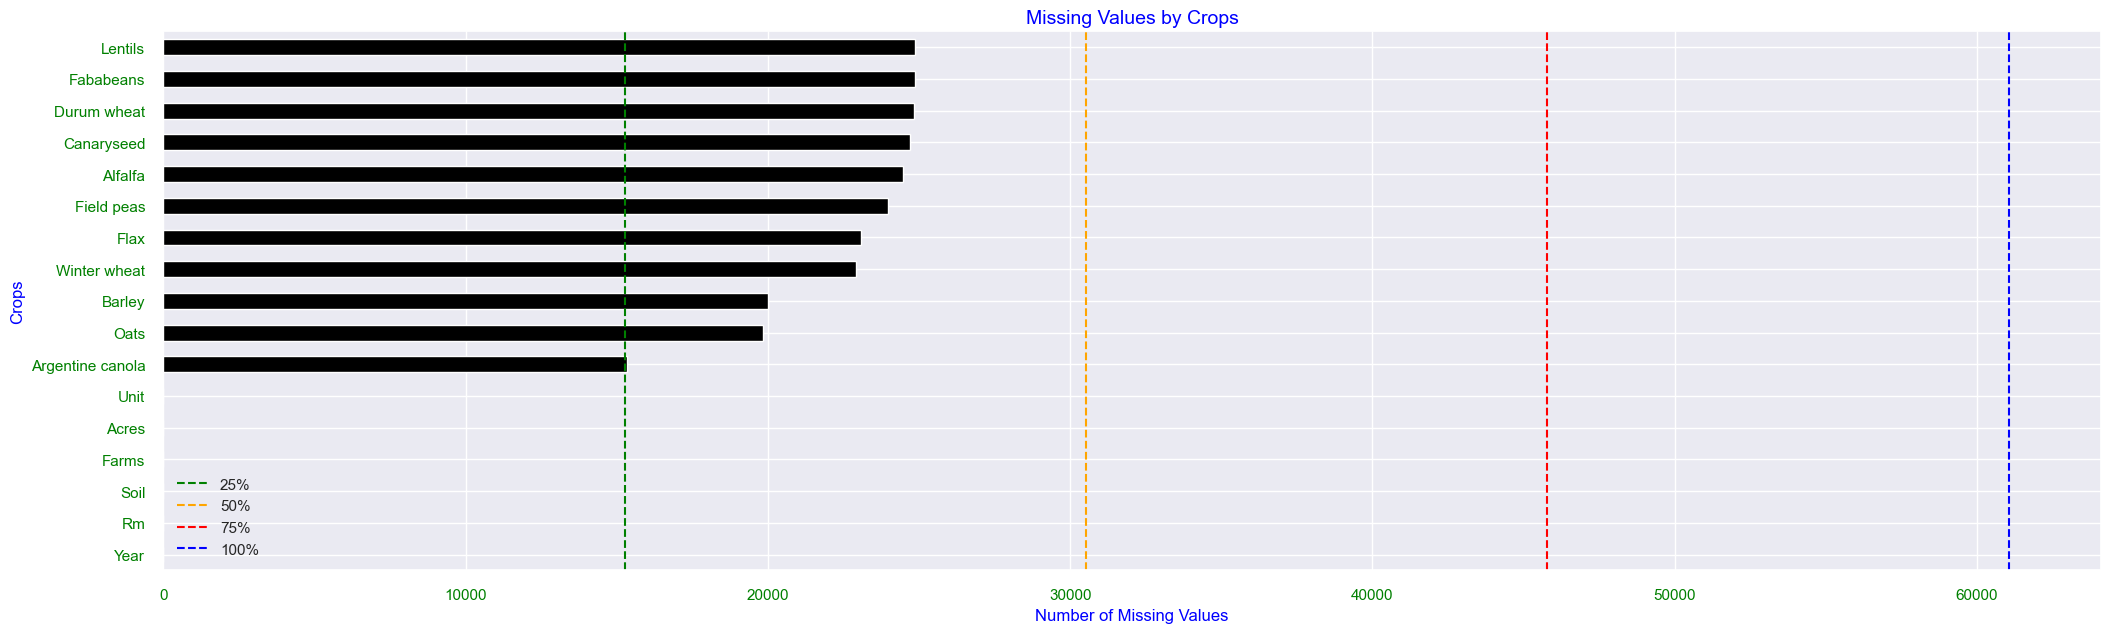

In [85]:
# Checking for missing values

df_data.isna().sum()\
    .sort_values()\
    .plot(kind='barh', color='black')
plt.title('Missing Values by Crops', color= 'blue', size = 14)
plt.xlabel('Number of Missing Values', color= 'blue', size = 12)
plt.ylabel ('Crops', color= 'blue', size = 12)
plt.xticks(color='green')
plt.yticks(color='green')
# length of original dataframe is 100% of records 
plt.axvline(len(df_clean_2)*.25, color='green', linestyle='--', label='25%') # half of dataset
plt.axvline(len(df_clean_2)/2, color='orange', linestyle='--', label='50%') # half of dataset
plt.axvline(len(df_clean_2) * 0.75 , color='red', linestyle='--', label='75%') # 75% of dataset
plt.axvline(len(df_clean_2) , color='blue', linestyle='--', label='100%') # 100% of dataset
plt.legend()
plt.show()

In [86]:
df_data.describe().drop(columns=['Year', 'Farms']).drop('count', axis=0)

Crop   Alfalfa  Argentine canola      Barley   Canaryseed  Durum wheat  \
mean  2.111202         34.530714   64.857677   965.835165    36.648571   
std   0.915581          9.994812   19.214300   522.927528     7.872181   
min   0.257000          0.300000    3.900000    44.000000    18.000000   
25%   1.436500         28.000000   52.800000   538.500000    31.700000   
50%   2.053000         35.100000   65.800000   948.000000    37.450000   
75%   2.767000         42.000000   78.500000  1339.000000    40.875000   
max   6.505000         85.100000  116.900000  2567.000000    54.100000   

Crop    Fababeans  Field peas       Flax      Lentils        Oats  \
mean  2274.200000   43.427948  20.966078  1196.000000   91.691817   
std    688.213751   13.885639   6.812380   584.141155   28.909526   
min    706.000000    3.000000   0.000000   327.000000    6.900000   
25%   1925.000000   35.075000  16.800000   850.500000   71.100000   
50%   2263.000000   42.850000  21.000000   997.500000   91.700000   
75%   2668.000000   52.600000  25.200000  1434.250000  112.000000   
max   3662.000000   80.000000  46.400000  2211.000000  185.900000   

Crop  Winter wheat  
mean     63.232145  
std      13.624436  
min       6.500000  
25%      54.700000  
50%      64.300000  
75%      73.000000  
max      96.000000

In [87]:
df_clean_2.head()

Year                RM        Crop Soil Farms    Acres       Yield  \
0  2003          MONTCALM  CANARYSEED    D     7      764  997 Pounds   
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0  991 Pounds   
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517  990 Pounds   
3  2009            MORRIS  CANARYSEED    D     3  1,072.0  980 Pounds   
4  2002            ROLAND  CANARYSEED    D     6      981  968 Pounds   

   Yield_Float    Unit  lbs_bushel  Yield_bushels  
0        997.0  Pounds          50          19.94  
1        991.0  Pounds          50          19.82  
2        990.0  Pounds          50          19.80  
3        980.0  Pounds          50          19.60  
4        968.0  Pounds          50          19.36

In [88]:
df_agg1=df_clean_2.drop(columns=['Year','Farms','RM', 'Soil', 'Acres', 'Unit','Yield'	,'Yield_Float'	,'lbs_bushel']).groupby(['Crop']).agg({'Yield_bushels':['mean','std']}).reset_index()
df_agg1.columns = [' '.join(col).strip() for col in df_agg1.columns.values]
df_agg1

Crop  Yield_bushels mean  Yield_bushels std
0            ALFALFA            2.111202           0.915581
1   ARGENTINE CANOLA           34.530714           9.994812
2             BARLEY           64.857677          19.214300
3         CANARYSEED           19.316703          10.458551
4        DURUM WHEAT           36.648571           7.872181
5          FABABEANS           37.903333          11.470229
6         FIELD PEAS           43.427948          13.885639
7               FLAX           20.966078           6.812380
8            LENTILS           19.933333           9.735686
9               OATS           91.691817          28.909526
10      WINTER WHEAT           63.232145          13.624436

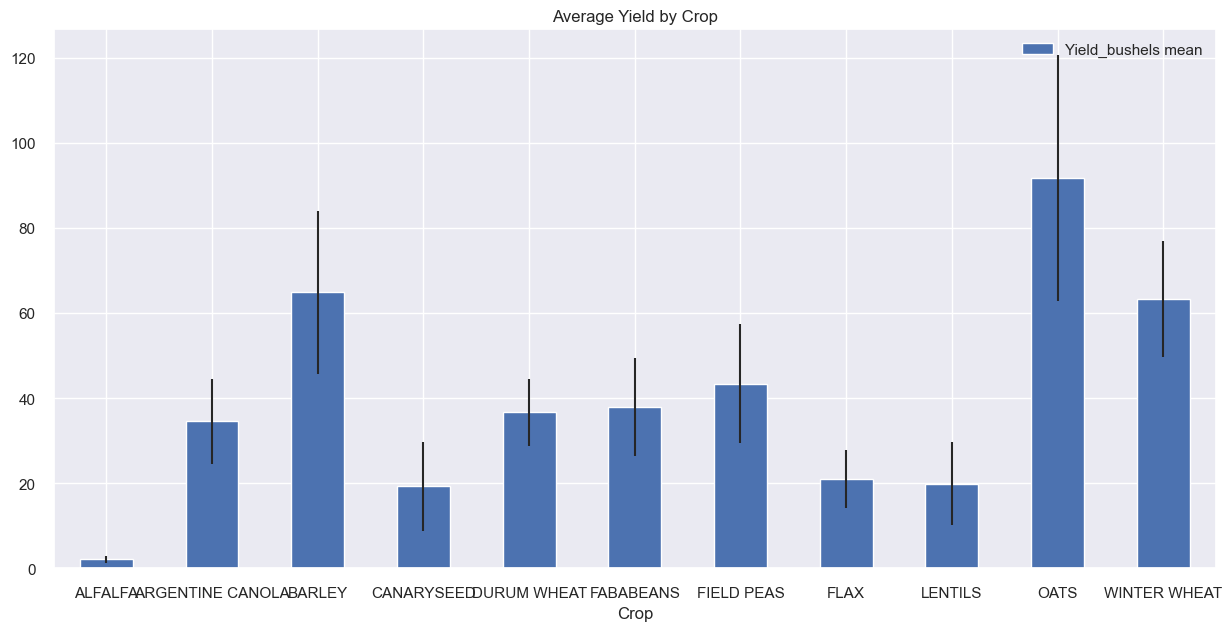

In [89]:
# Graphing each crops average yield
ax = df_agg1.plot(kind='bar', x='Crop', y='Yield_bushels mean', yerr='Yield_bushels std', rot=0,figsize=(15,7),title ='Average Yield by Crop')

                  


In [90]:
columns_yield = ['Alfalfa',
       'Argentine canola', 'Barley', 'Canaryseed', 'Durum wheat', 'Fababeans',
       'Field peas', 'Flax', 'Lentils', 'Oats', 'Winter wheat']

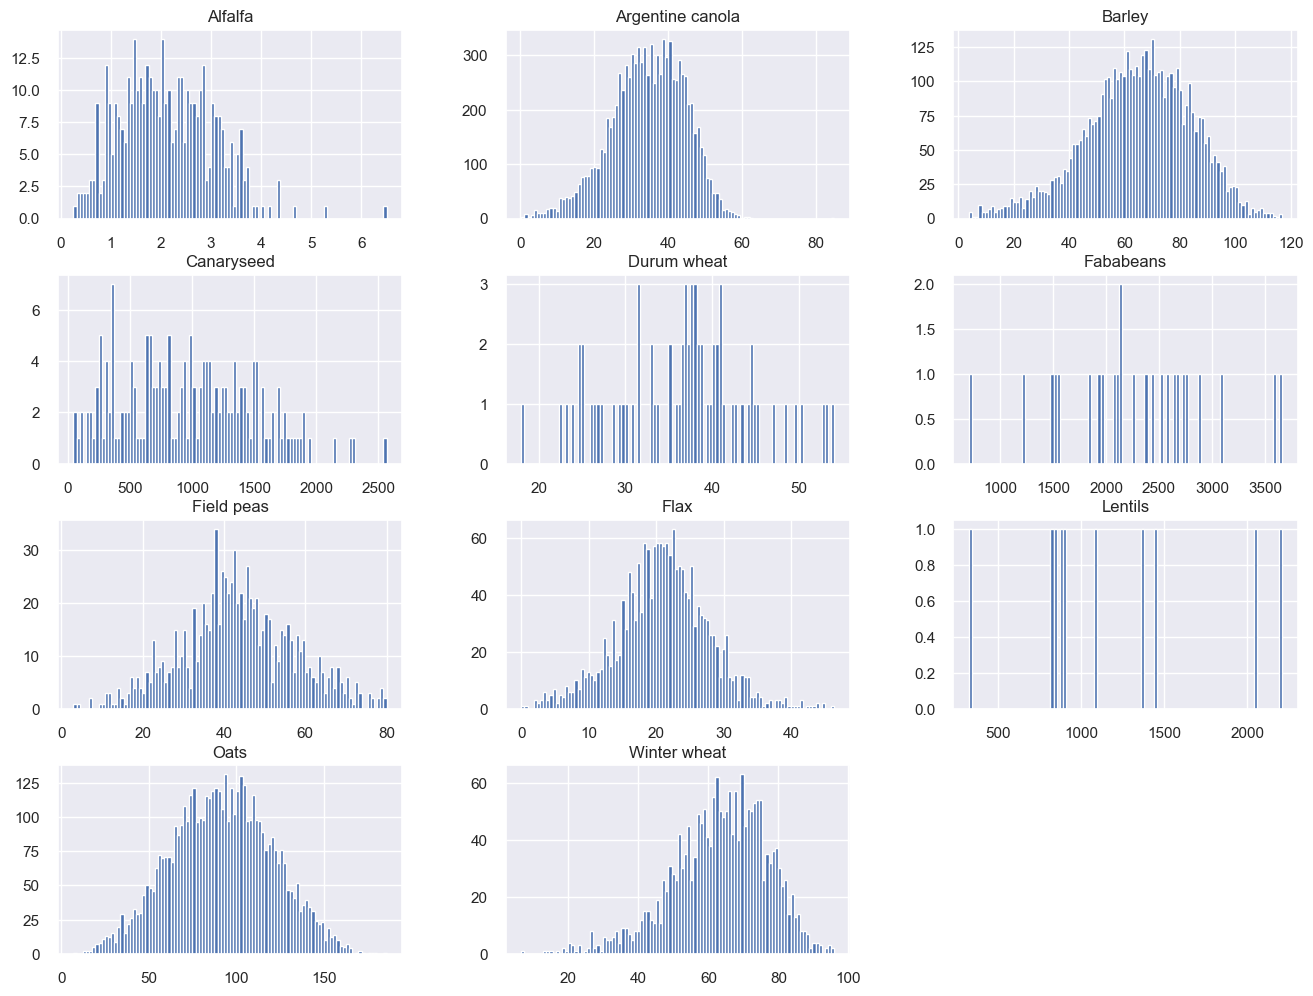

In [91]:
df_data[columns_yield].hist(figsize=(16,12),
                       bins=100)
plt.show()

In [92]:
# value counts of unique categorical items by crop

In [93]:
df_clean_2.head()

Year                RM        Crop Soil Farms    Acres       Yield  \
0  2003          MONTCALM  CANARYSEED    D     7      764  997 Pounds   
1  2004         PIPESTONE  CANARYSEED    F     8  1,180.0  991 Pounds   
2  2003  BIFROST-RIVERTON  CANARYSEED    F     4      517  990 Pounds   
3  2009            MORRIS  CANARYSEED    D     3  1,072.0  980 Pounds   
4  2002            ROLAND  CANARYSEED    D     6      981  968 Pounds   

   Yield_Float    Unit  lbs_bushel  Yield_bushels  
0        997.0  Pounds          50          19.94  
1        991.0  Pounds          50          19.82  
2        990.0  Pounds          50          19.80  
3        980.0  Pounds          50          19.60  
4        968.0  Pounds          50          19.36

In [94]:
df_clean_2.groupby(['Crop']).nunique()[['Soil','Farms','RM']].reset_index()

Crop  Soil  Farms  RM
0            ALFALFA    10     15  98
1   ARGENTINE CANOLA    11    133  99
2             BARLEY    10     79  99
3         CANARYSEED    10     22  84
4        DURUM WHEAT     9     18  53
5          FABABEANS    10      7  72
6         FIELD PEAS    10     30  96
7               FLAX    10     53  97
8            LENTILS    10      8  48
9               OATS    10     80  99
10      WINTER WHEAT    10     42  98

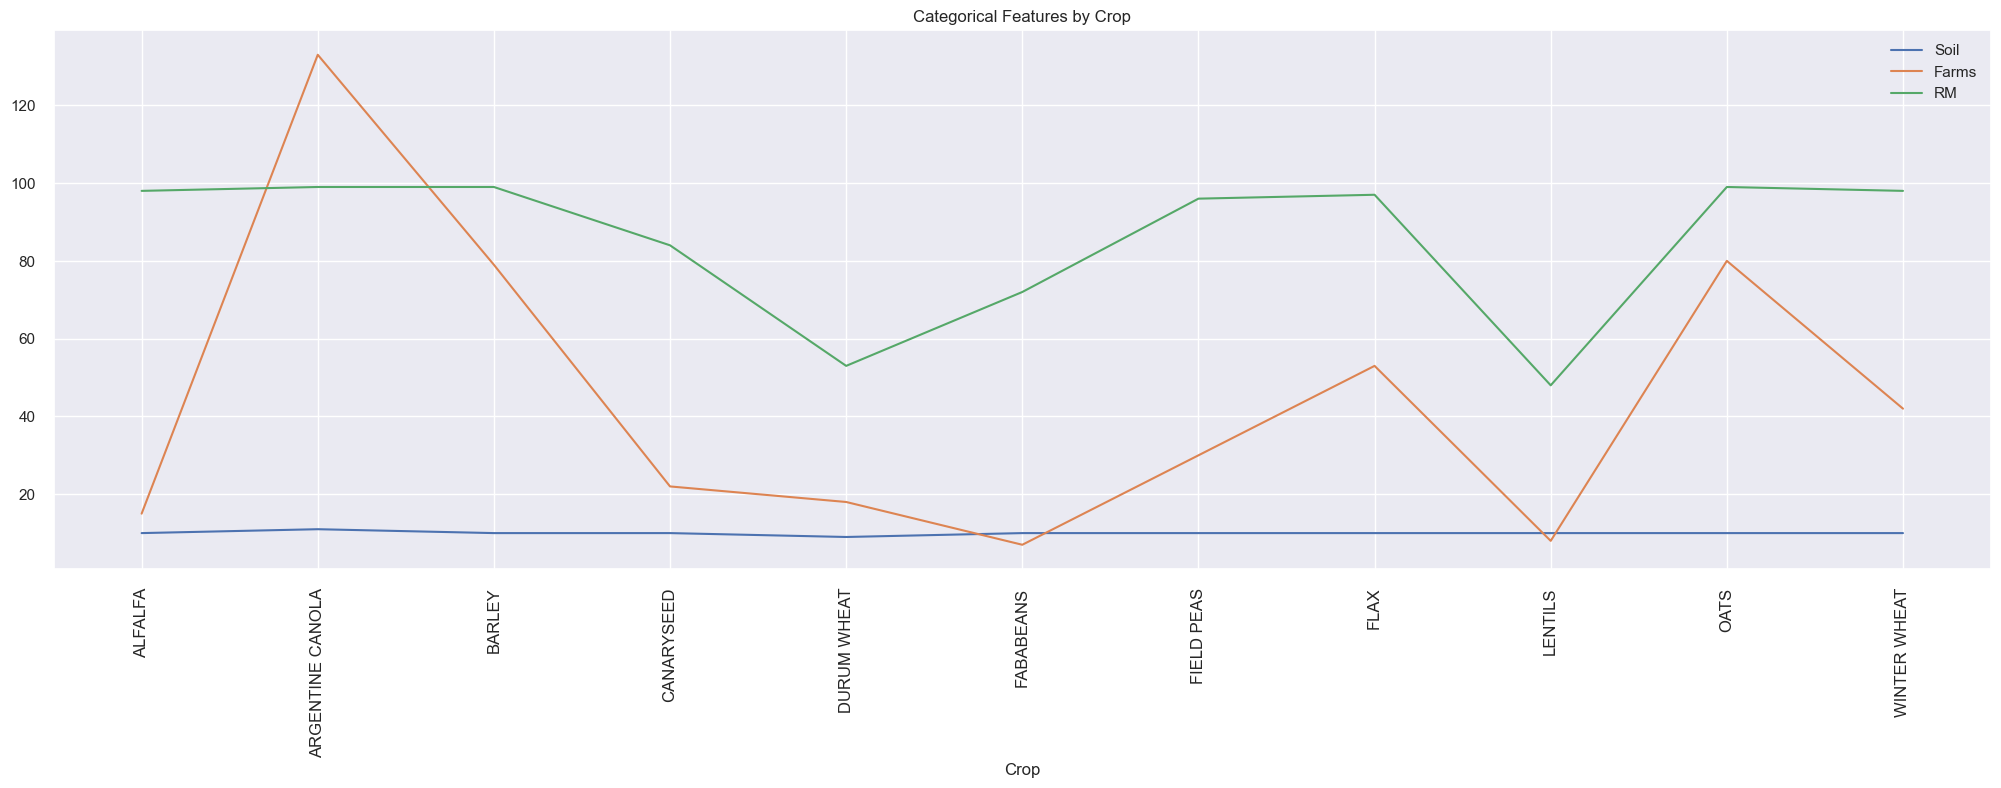

In [95]:
df_plot = df_clean_2.groupby(['Crop']).nunique()[['Soil','Farms','RM']].reset_index()
index=df_plot['Crop'].to_list()

df_plot.plot(x='Crop',figsize=(25,7),rot=90,title='Categorical Features by Crop')
plt.xticks(list(range(len(index))), index, fontsize=12)
plt.show()


In [ ]:
df_clean_2.groupby(['RM'])

In [96]:
df_clean_2.groupby(['Crop','Year'])['Yield_bushels'].sum().reset_index()

Crop  Year  Yield_bushels
0             ALFALFA  2000      21.625000
1             ALFALFA  2001      25.234000
2             ALFALFA  2002      40.062000
3             ALFALFA  2003      46.456000
4             ALFALFA  2004     101.951000
5             ALFALFA  2005      46.522000
6             ALFALFA  2006      25.073000
7             ALFALFA  2007      24.337000
8             ALFALFA  2008       8.470000
9             ALFALFA  2009      13.024000
10            ALFALFA  2010       5.529000
11            ALFALFA  2011       2.509000
12            ALFALFA  2012       1.453000
13            ALFALFA  2013       6.026000
14            ALFALFA  2014      17.574000
15            ALFALFA  2015      30.413000
16            ALFALFA  2016      47.761000
17            ALFALFA  2017      24.346000
18            ALFALFA  2018      25.105000
19            ALFALFA  2019      73.013000
20            ALFALFA  2020     112.266000
21            ALFALFA  2021      54.712000
22            ALFALFA  2022     122.688000
23   ARGENTINE CANOLA  2000   11130.700000
24   ARGENTINE CANOLA  2001    9560.200000
25   ARGENTINE CANOLA  2002   11677.300000
26   ARGENTINE CANOLA  2003   12520.400000
27   ARGENTINE CANOLA  2004   12646.200000
28   ARGENTINE CANOLA  2005    9100.800000
29   ARGENTINE CANOLA  2006   12628.900000
30   ARGENTINE CANOLA  2007   11026.800000
31   ARGENTINE CANOLA  2008   15857.300000
32   ARGENTINE CANOLA  2009   16849.800000
33   ARGENTINE CANOLA  2010   12835.600000
34   ARGENTINE CANOLA  2011   10651.900000
35   ARGENTINE CANOLA  2012   11504.600000
36   ARGENTINE CANOLA  2013   17884.200000
37   ARGENTINE CANOLA  2014   14640.800000
38   ARGENTINE CANOLA  2015   17826.400000
39   ARGENTINE CANOLA  2016   16449.000000
40   ARGENTINE CANOLA  2017   19784.600000
41   ARGENTINE CANOLA  2018   19120.400000
42   ARGENTINE CANOLA  2019   18200.800000
43   ARGENTINE CANOLA  2020   18306.000000
44   ARGENTINE CANOLA  2021   12703.800000
45   ARGENTINE CANOLA  2022   16620.100000
46             BARLEY  2000   19927.600000
47             BARLEY  2001   15487.100000
48             BARLEY  2002   15961.600000
49             BARLEY  2003   20844.100000
50             BARLEY  2004   19952.800000
51             BARLEY  2005    9640.400000
52             BARLEY  2006   17077.600000
53             BARLEY  2007   17811.200000
54             BARLEY  2008   17410.100000
55             BARLEY  2009   16466.000000
56             BARLEY  2010   10211.000000
57             BARLEY  2011    4907.600000
58             BARLEY  2012   11322.000000
59             BARLEY  2013   17019.800000
60             BARLEY  2014    9912.500000
61             BARLEY  2015   12623.500000
62             BARLEY  2016   12048.300000
63             BARLEY  2017    9786.000000
64             BARLEY  2018    9115.900000
65             BARLEY  2019   12759.700000
66             BARLEY  2020   14186.400000
67             BARLEY  2021    9894.300000
68             BARLEY  2022   12853.400000
69         CANARYSEED  2000     348.300000
70         CANARYSEED  2001     176.400000
71         CANARYSEED  2002     752.500000
72         CANARYSEED  2003     550.820000
73         CANARYSEED  2004     329.480000
74         CANARYSEED  2005      27.040000
75         CANARYSEED  2006      59.500000
76         CANARYSEED  2007     165.860000
77         CANARYSEED  2008     217.920000
78         CANARYSEED  2009     182.860000
79         CANARYSEED  2010     200.880000
80         CANARYSEED  2011      12.560000
81         CANARYSEED  2012     120.180000
82         CANARYSEED  2013      39.160000
83         CANARYSEED  2014       0.000000
84         CANARYSEED  2015     177.300000
85         CANARYSEED  2016      68.280000
86         CANARYSEED  2017       0.000000
87         CANARYSEED  2018       0.000000
88         CANARYSEED  2019       0.000000
89         CANARYSEED  2020      10.620000
90         CANARYSEED  2021      70.020000
91         CANARYSEED  2022       5.960000
92        DURUM WH

[Text(0.5, 1.0, 'Total Yield by Year')]

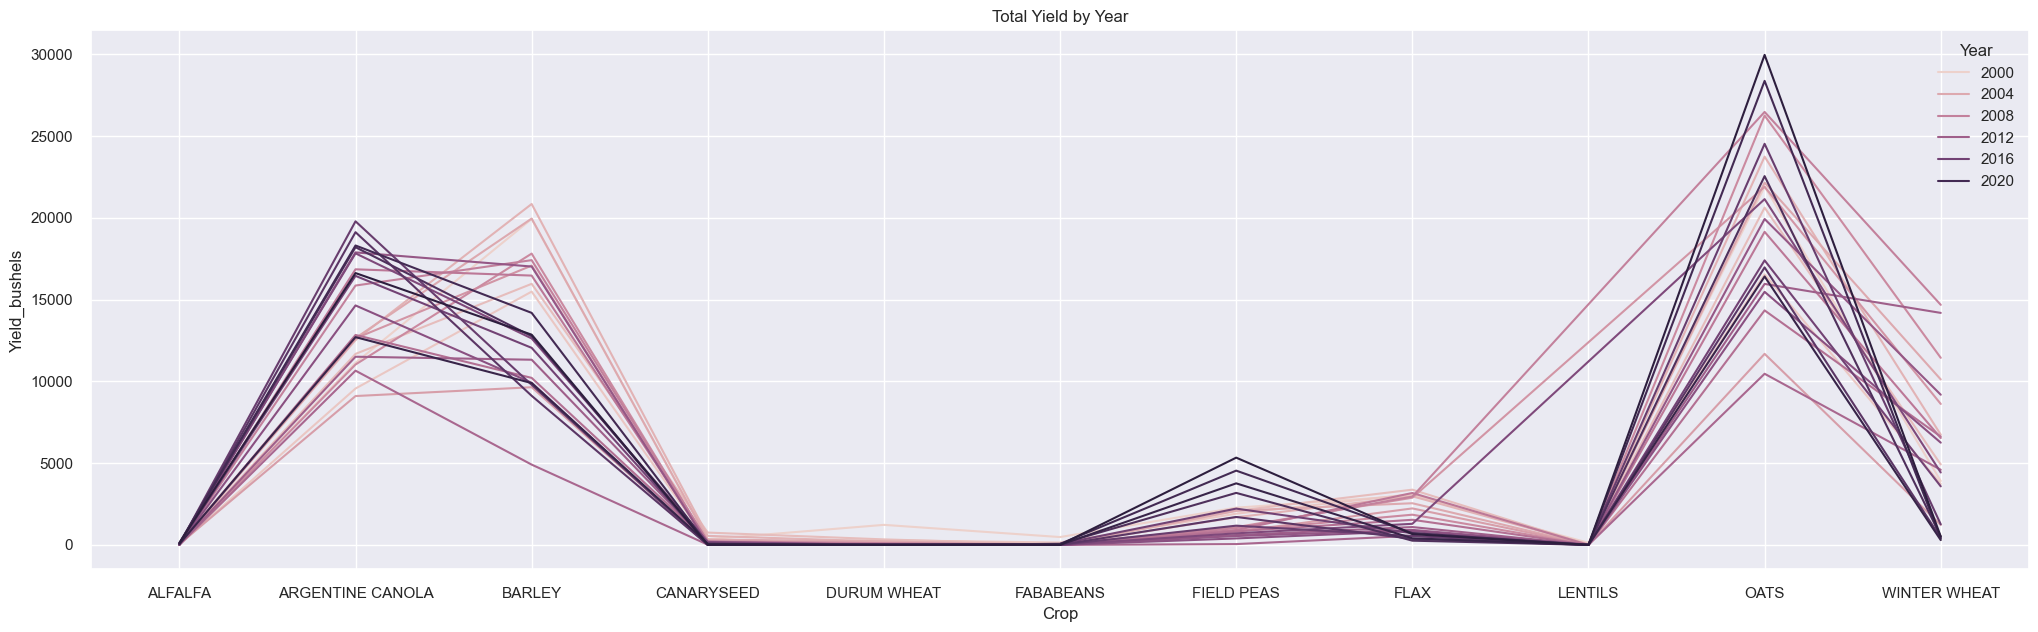

In [97]:
df_plot_year = df_clean_2.groupby(['Crop','Year'])['Yield_bushels'].sum().reset_index()
sns.set(rc={"figure.figsize":(25, 7)}) #width=3, #height=4
sns.lineplot(x='Crop', y='Yield_bushels', hue='Year', data=df_plot_year).set(title='Total Yield by Year')


[Text(0.5, 1.0, 'Average Yield by Year')]

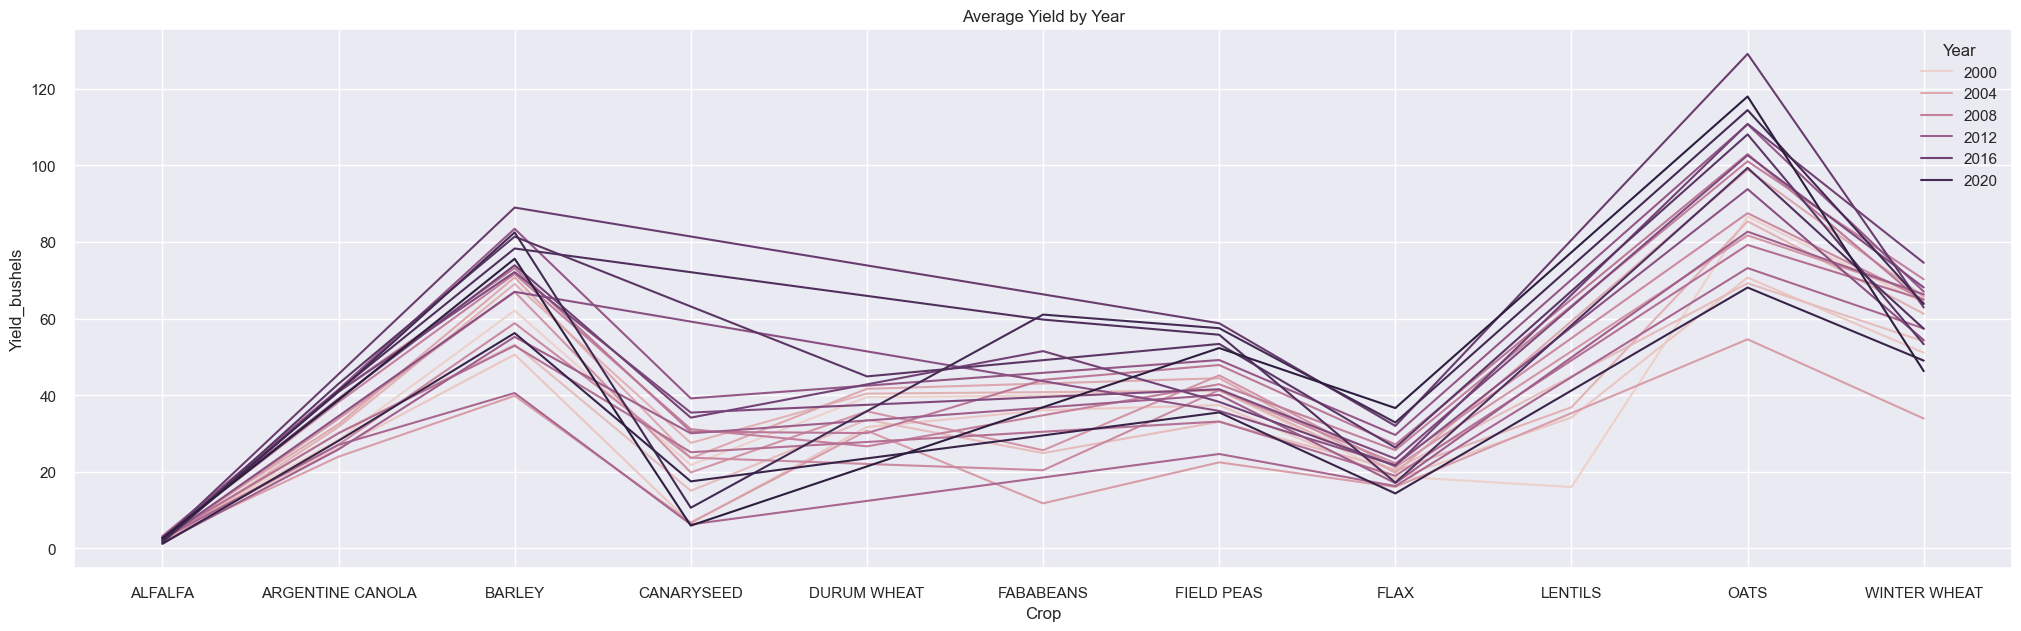

In [98]:
df_plot_year = df_clean_2.groupby(['Crop','Year'])['Yield_bushels'].mean().reset_index()
sns.set(rc={"figure.figsize":(25, 7)}) #width=3, #height=4
sns.lineplot(x='Crop', y='Yield_bushels', hue='Year', data=df_plot_year).set(title='Average Yield by Year')


<h1>Crop Selection</h1>
<p>I am going to focus on Oats as it has high yield but also a lot of diversity in terms of standard deviation as can be seen in the bar graph on overall yield and the line-graph showing unique farms/soil/region per crop.</p>
    
<p>I believe these features will lead to an interesting analysis. </p>

<h1>Feature Exploration

In [99]:
df_oats = df_clean_2[df_clean_2['Crop']=='OATS']
df_oats.head()

Year        RM  Crop Soil Farms    Acres          Yield  Yield_Float  \
2102  2017   CARTIER  OATS    E     5      760  185.9 Bushels        185.9   
2103  2017  ROCKWOOD  OATS    C     3      511  179.1 Bushels        179.1   
2104  2017   CARTIER  OATS    B     6  1,057.0  178.3 Bushels        178.3   
2105  2013  MCCREARY  OATS    C     3      735  175.9 Bushels        175.9   
2106  2022     LORNE  OATS    C    19  3,041.0  173.0 Bushels        173.0   

         Unit  lbs_bushel  Yield_bushels  
2102  Bushels          34          185.9  
2103  Bushels          34          179.1  
2104  Bushels          34          178.3  
2105  Bushels          34          175.9  
2106  Bushels          34          173.0

In [176]:
df_oats.shape

(11599, 11)

In [100]:
# For the purpose of the clustering i will keep the null yields as such or 0 as I am curious to see if there are 
# any common characteristics of null or insignificant yields in Oats
df_oats.isnull().sum()

Year                0
RM                  0
Crop                0
Soil                0
Farms               0
Acres               0
Yield            6540
Yield_Float      6540
Unit             6540
lbs_bushel          0
Yield_bushels    6540
dtype: int64

In [101]:
df_oats.dtypes

Year               int64
RM                object
Crop              object
Soil              object
Farms             object
Acres             object
Yield             object
Yield_Float      float64
Unit              object
lbs_bushel         int64
Yield_bushels    float64
dtype: object

In [102]:
df_oats[df_oats['Yield'].isnull()==True].head()
# 

Year         RM  Crop Soil  Farms    Acres Yield  Yield_Float Unit  \
7161  2000  ALEXANDER  OATS    G  Below  Minimum   NaN          NaN  NaN   
7162  2000  ALEXANDER  OATS    J  Below  Minimum   NaN          NaN  NaN   
7163  2000     ALONSA  OATS    F  Below  Minimum   NaN          NaN  NaN   
7164  2000     ALONSA  OATS    G  Below  Minimum   NaN          NaN  NaN   
7165  2000     ALONSA  OATS    H  Below  Minimum   NaN          NaN  NaN   

      lbs_bushel  Yield_bushels  
7161          34            NaN  
7162          34            NaN  
7163          34            NaN  
7164          34            NaN  
7165          34            NaN

In [179]:
df_oats['Yield_bushels'].mean()

91.69181656453846

In [105]:
# Need to replace "Below" and "Minimum" with null and strip comma


df_oats['Farms'] = df_oats['Farms'].replace('Below',np.nan).astype(float)
df_oats['Acres'] = df_oats['Acres'].replace('Minimum',np.nan)
df_oats['Acres']= np.where(df_oats['Acres'].str.contains(',')==True,df_oats['Acres'].str.replace(',',''),df_oats['Acres']).astype(float)


df_oats.head()

C:\Users\giacr\AppData\Local\Temp\ipykernel_8136\3229193261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oats['Farms'] = df_oats['Farms'].replace('Below',np.nan).astype(float)
C:\Users\giacr\AppData\Local\Temp\ipykernel_8136\3229193261.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oats['Acres'] = df_oats['Acres'].replace('Minimum',np.nan)
C:\Users\giacr\AppData\Local\Temp\ipykernel_8136\3229193261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Year        RM  Crop Soil  Farms   Acres          Yield  Yield_Float  \
2102  2017   CARTIER  OATS    E    5.0   760.0  185.9 Bushels        185.9   
2103  2017  ROCKWOOD  OATS    C    3.0   511.0  179.1 Bushels        179.1   
2104  2017   CARTIER  OATS    B    6.0  1057.0  178.3 Bushels        178.3   
2105  2013  MCCREARY  OATS    C    3.0   735.0  175.9 Bushels        175.9   
2106  2022     LORNE  OATS    C   19.0  3041.0  173.0 Bushels        173.0   

         Unit  lbs_bushel  Yield_bushels  
2102  Bushels          34          185.9  
2103  Bushels          34          179.1  
2104  Bushels          34          178.3  
2105  Bushels          34          175.9  
2106  Bushels          34          173.0

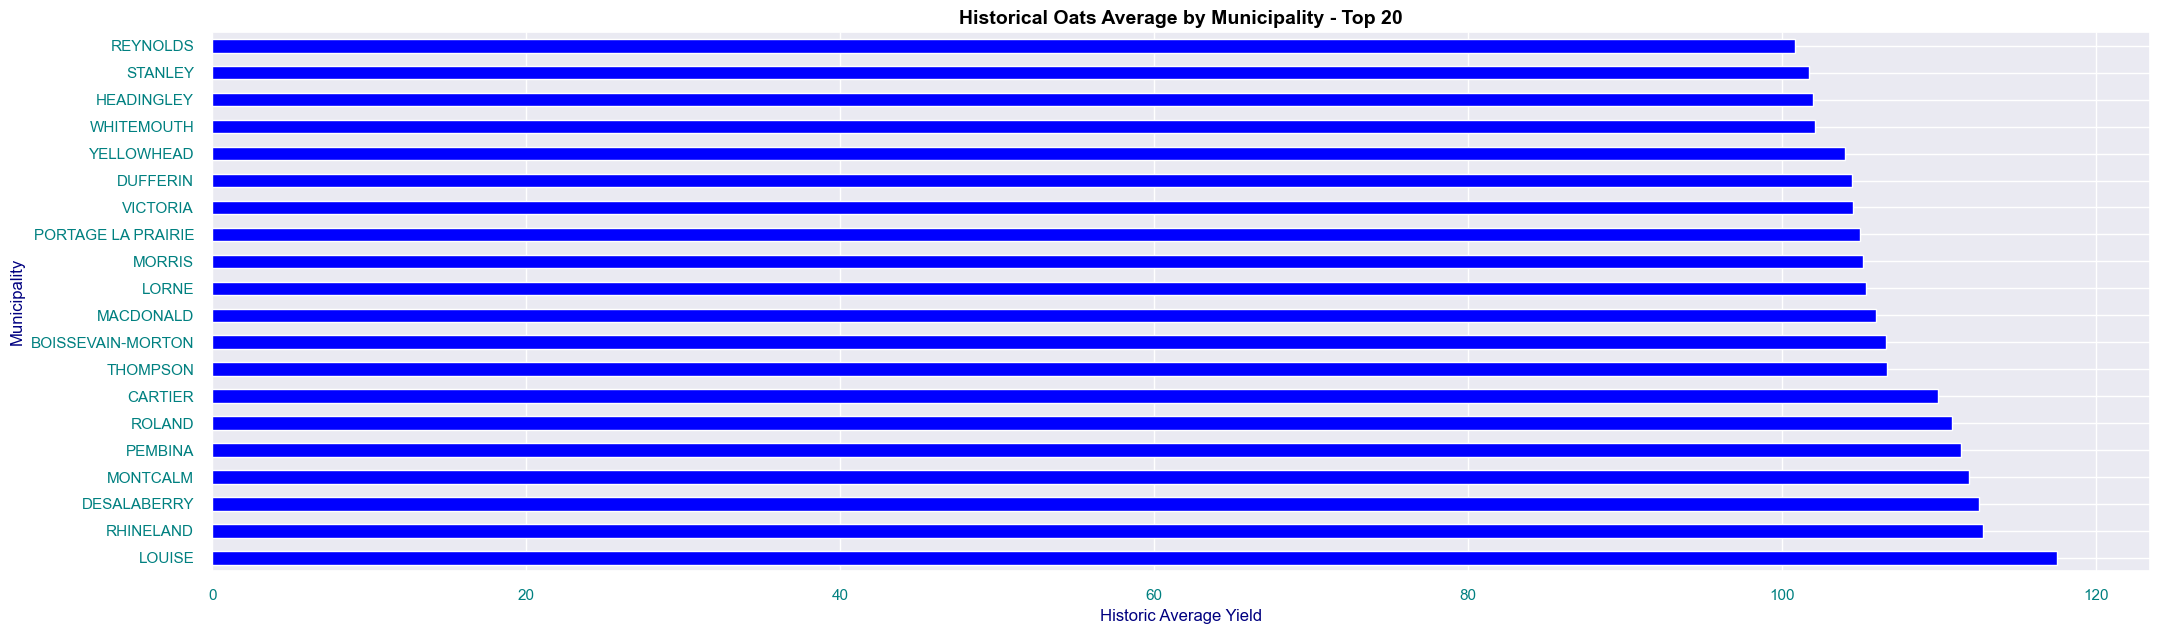

In [106]:
# Dp it by year to see if there is a difference
# groupby is function that aggragates data based on index or categorical variable
df_oats.groupby(['RM'])['Yield_bushels'].mean()\
    .sort_values(ascending=False)[:20]\
    .plot(kind='barh', color='blue')
plt.title('Historical Oats Average by Municipality - Top 20', color= 'black', size = 14, fontweight='bold')
plt.xlabel('Historic Average Yield', color= 'navy', size = 12)
plt.ylabel ('Municipality', color= 'navy', size = 12)
plt.xticks(color='teal')
plt.yticks(color='teal')
plt.show()


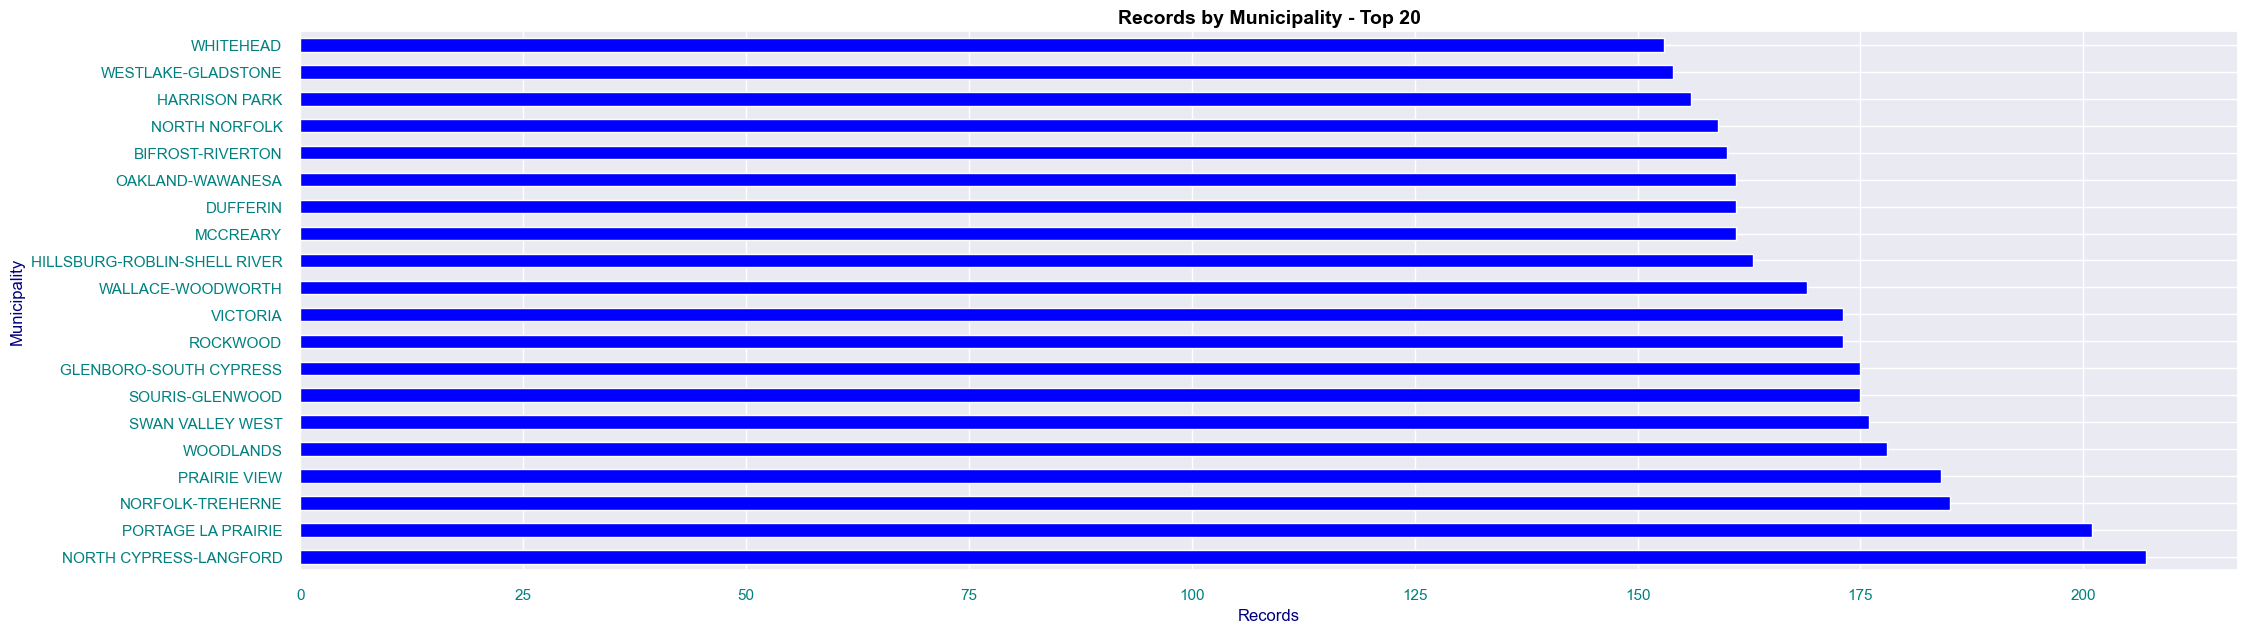

In [178]:
df_oats.groupby(['RM'])['Soil'].count()\
    .sort_values(ascending=False)[:20]\
    .plot(kind='barh', color='blue')
plt.title('Records by Municipality - Top 20', color= 'black', size = 14, fontweight='bold')
plt.xlabel('Records', color= 'navy', size = 12)
plt.ylabel ('Municipality', color= 'navy', size = 12)
plt.xticks(color='teal')
plt.yticks(color='teal')
plt.show()

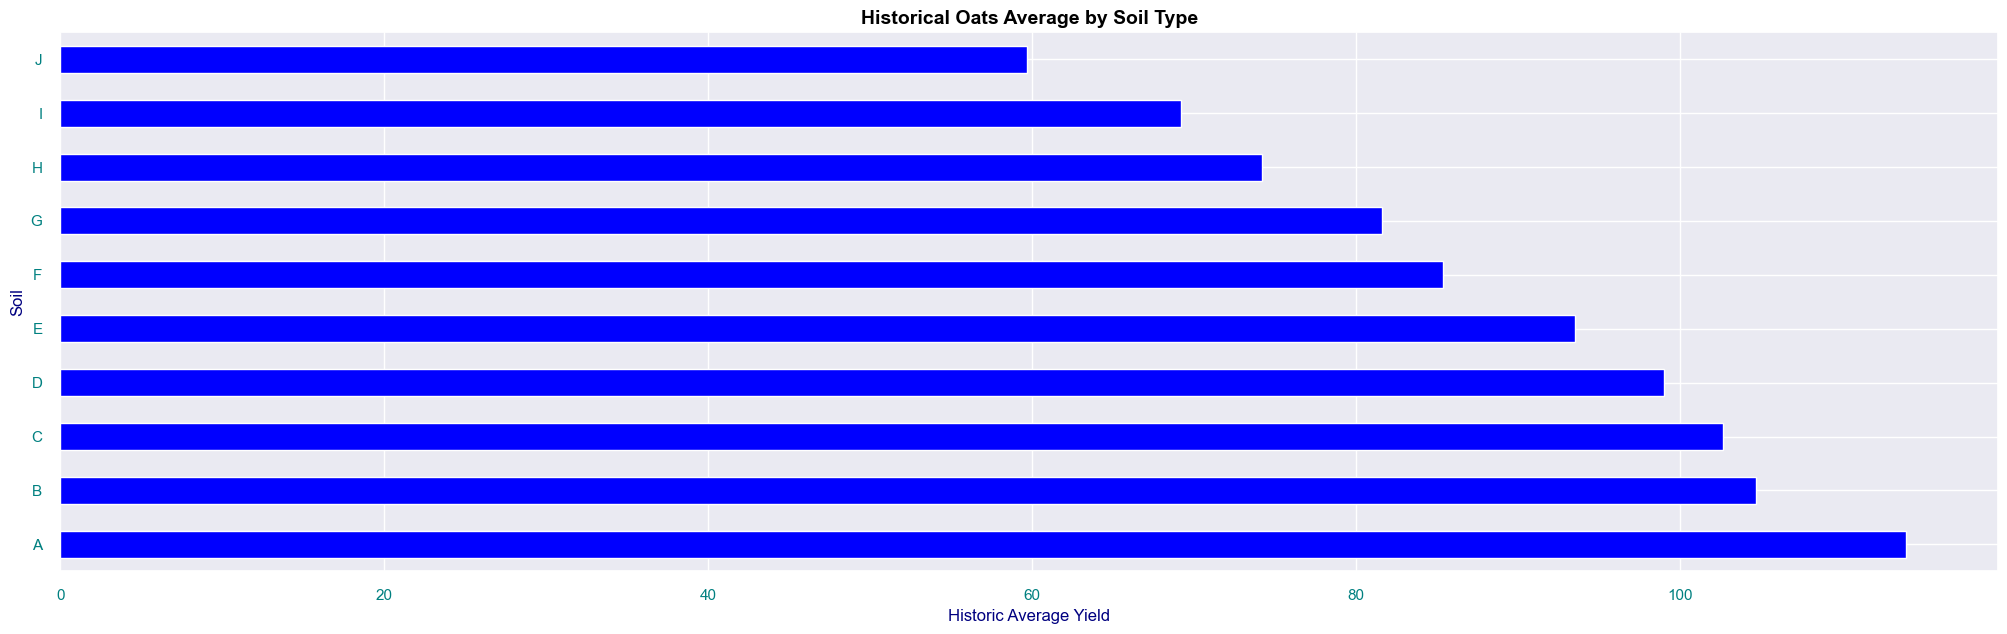

In [107]:
df_oats.groupby(['Soil'])['Yield_bushels'].mean()\
    .sort_values(ascending=False)[:20]\
    .plot(kind='barh', color='blue')
plt.title('Historical Oats Average by Soil Type', color= 'black', size = 14, fontweight='bold')
plt.xlabel('Historic Average Yield', color= 'navy', size = 12)
plt.ylabel ('Soil', color= 'navy', size = 12)
plt.xticks(color='teal')
plt.yticks(color='teal')
plt.show()

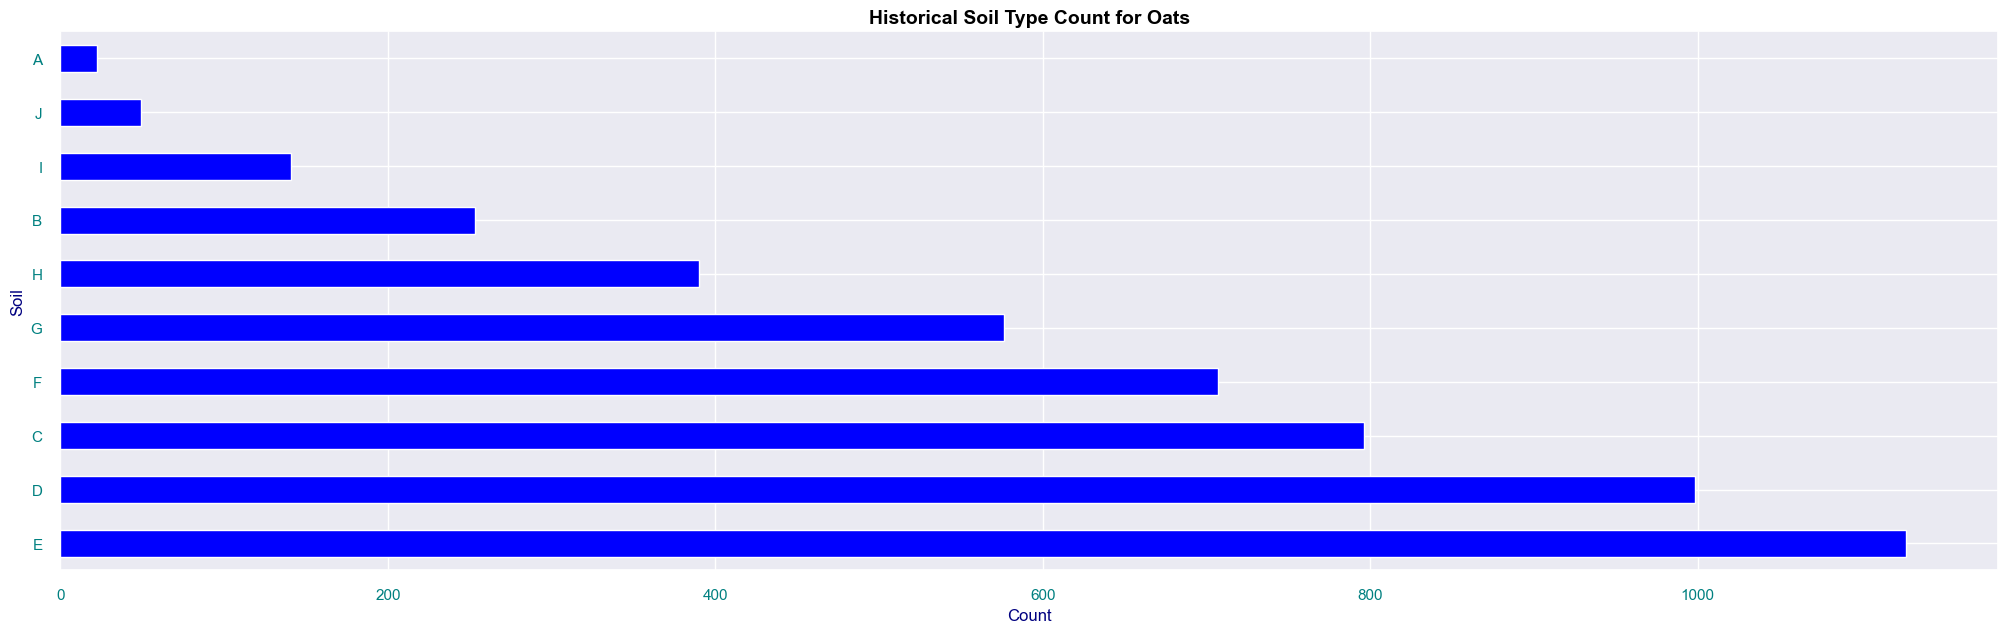

In [180]:
df_oats.groupby(['Soil'])['Yield_bushels'].count()\
    .sort_values(ascending=False)[:20]\
    .plot(kind='barh', color='blue')
plt.title('Historical Soil Type Count for Oats', color= 'black', size = 14, fontweight='bold')
plt.xlabel('Count', color= 'navy', size = 12)
plt.ylabel ('Soil', color= 'navy', size = 12)
plt.xticks(color='teal')
plt.yticks(color='teal')
plt.show()

In [108]:
# correlation heatmap sns

In [109]:
df_oats.columns

Index(['Year', 'RM', 'Crop', 'Soil', 'Farms', 'Acres', 'Yield', 'Yield_Float',
       'Unit', 'lbs_bushel', 'Yield_bushels'],
      dtype='object')

In [110]:
df_oats.head()

Year        RM  Crop Soil  Farms   Acres          Yield  Yield_Float  \
2102  2017   CARTIER  OATS    E    5.0   760.0  185.9 Bushels        185.9   
2103  2017  ROCKWOOD  OATS    C    3.0   511.0  179.1 Bushels        179.1   
2104  2017   CARTIER  OATS    B    6.0  1057.0  178.3 Bushels        178.3   
2105  2013  MCCREARY  OATS    C    3.0   735.0  175.9 Bushels        175.9   
2106  2022     LORNE  OATS    C   19.0  3041.0  173.0 Bushels        173.0   

         Unit  lbs_bushel  Yield_bushels  
2102  Bushels          34          185.9  
2103  Bushels          34          179.1  
2104  Bushels          34          178.3  
2105  Bushels          34          175.9  
2106  Bushels          34          173.0

<h1> Feature Building

In [111]:
# select features to analyze
df_oats_feature = df_oats[['RM','Soil', 'Farms','Acres','Yield_bushels']]
# separate df with year
df_oats_feature_year = df_oats[['Year','RM','Soil', 'Farms','Acres','Yield_bushels']]


In [112]:
# one hot encode categorical variables  - convert to 0 or 1
df_oats_feature_2 = pd.get_dummies(df_oats_feature, columns=['RM','Soil'], drop_first=True)
df_oats_feature_2

Farms   Acres  Yield_bushels  RM_ALONSA  RM_ARGYLE  RM_ARMSTRONG  \
2102     5.0   760.0          185.9      False      False         False   
2103     3.0   511.0          179.1      False      False         False   
2104     6.0  1057.0          178.3      False      False         False   
2105     3.0   735.0          175.9      False      False         False   
2106    19.0  3041.0          173.0      False      False         False   
...      ...     ...            ...        ...        ...           ...   
13696    NaN     NaN            NaN      False      False         False   
13697    NaN     NaN            NaN      False      False         False   
13698    NaN     NaN            NaN      False      False         False   
13699    NaN     NaN            NaN      False      False         False   
13700    NaN     NaN            NaN      False      False         False   

       RM_BIFROST-RIVERTON  RM_BOISSEVAIN-MORTON  RM_BRENDA-WASKADA  \
2102                 False                 False              False   
2103                 False                 False              False   
2104                 False                 False              False   
2105                 False                 False              False   
2106                 False                 False              False   
...                    ...                   ...                ...   
13696                False                 False              False   
13697                False                 False              False   
13698                False                 False              False   
13699                False                 False              False   
13700                False                 False              False   

       RM_BROKENHEAD  RM_CARTIER  RM_CARTWRIGHT-ROBLIN  \
2102           False        True                 False   
2103           False       False                 False   
2104           False        True                 False   
2105           False       False                 False   
2106           False       False                 False   
...              ...         ...                   ...   
13696          False       False                 False   
13697          False       False                 False   
13698          False       False                 False   
13699          False       False                 False   
13700          False       False                 False   

       RM_CLANWILLIAM-ERICKSON  RM_COLDWELL  RM_CORNWALLIS  RM_DAUPHIN  \
2102                     False        False          False       False   
2103                     False        False          False       False   
2104                     False        False          False       False   
2105                     False        False          False       False   
2106                     False        False          False       False   
...                        ...          ...            ...         ...   
13696                    False        False          False       False   
13697                    False        False          False       False   
13698                    False        False          False       False   
13699                    False        False          False       False   
13700                    False        False          False       False   

       RM_DELORAINE-WINCHESTER  RM_DESALABERRY  RM_DUFFERIN  RM_EAST ST PAUL  \
2102                     False           False        False            False   
2103                     False           False        False            False   
2104                     False           False        False            False   
2105                     False           False        False            False   
2106                     False           False        False            False   
...                        ...             ...          ...              ...   
13696                    False           False        False            False   
13697                    Fa

In [113]:
def normalize(df,column):
    return (df[column] - df[column].min()) / (df[column].max() - df[column].min())     


In [114]:
df_oats_feature_2['Farms_norm'] =  normalize(df_oats_feature_2,'Farms')     
df_oats_feature_2['Acres_norm'] =  normalize(df_oats_feature_2,'Acres')     
df_oats_feature_2['Yield_bushels_norm'] =  normalize(df_oats_feature_2,'Yield_bushels')   

df_oats_feature_2.head()

Farms   Acres  Yield_bushels  RM_ALONSA  RM_ARGYLE  RM_ARMSTRONG  \
2102    5.0   760.0          185.9      False      False         False   
2103    3.0   511.0          179.1      False      False         False   
2104    6.0  1057.0          178.3      False      False         False   
2105    3.0   735.0          175.9      False      False         False   
2106   19.0  3041.0          173.0      False      False         False   

      RM_BIFROST-RIVERTON  RM_BOISSEVAIN-MORTON  RM_BRENDA-WASKADA  \
2102                False                 False              False   
2103                False                 False              False   
2104                False                 False              False   
2105                False                 False              False   
2106                False                 False              False   

      RM_BROKENHEAD  RM_CARTIER  RM_CARTWRIGHT-ROBLIN  \
2102          False        True                 False   
2103          False       False                 False   
2104          False        True                 False   
2105          False       False                 False   
2106          False       False                 False   

      RM_CLANWILLIAM-ERICKSON  RM_COLDWELL  RM_CORNWALLIS  RM_DAUPHIN  \
2102                    False        False          False       False   
2103                    False        False          False       False   
2104                    False        False          False       False   
2105                    False        False          False       False   
2106                    False        False          False       False   

      RM_DELORAINE-WINCHESTER  RM_DESALABERRY  RM_DUFFERIN  RM_EAST ST PAUL  \
2102                    False           False        False            False   
2103                    False           False        False            False   
2104                    False           False        False            False   
2105                    False           False        False            False   
2106                    False           False        False            False   

      RM_ELLICE-ARCHIE  RM_ELTON  RM_EMERSON-FRANKLIN  RM_ETHELBERT  \
2102             False     False                False         False   
2103             False     False                False         False   
2104             False     False                False         False   
2105             False     False                False         False   
2106             False     False                False         False   

      RM_FISHER  RM_GILBERT PLAINS  RM_GIMLI  RM_GLENBORO-SOUTH CYPRESS  \
2102      False              False     False                      False   
2103      False              False     False                      False   
2104      False              False     False                      False   
2105      False              False     False                      False   
2106      False              False     False                      False   

      RM_GLENELLA-LANSDOWNE  RM_GRAHAMDALE  RM_GRANDVIEW  RM_GRASSLAND  \
2102                  False          False         False         False   
2103                  False          False         False         False   
2104                  False          False         False         False   
2105                  False          False         False         False   
2106                  False          False         False         False   

      RM_GREY  RM_HAMIOTA  RM_HANOVER  RM_HARRISON PARK  RM_HEADINGLEY  \
2102    False       False       False             False          False   
2103    False       False       False             False          False   
2104    False       False       False             False          False   
2105    False       False       False             False          False   
2106    False       False       False             False          False   

      RM_HILLSBURG-ROBLIN-SHELL RIVER  RM_KELSEY  RM_KILLARNEY-TURTLE MTN  \
2102                            False 

In [115]:
df_oats_feature_2.shape

(11599, 113)

In [116]:
df_oats_feature_2_norm =df_oats_feature_2.drop(columns=['Farms',
'Acres',
'Yield_bushels'
])

In [117]:
df_oats_feature_2_norm.corr()

RM_ALONSA  RM_ARGYLE  RM_ARMSTRONG  \
RM_ALONSA                         1.000000  -0.010638     -0.007673   
RM_ARGYLE                        -0.010638   1.000000     -0.009386   
RM_ARMSTRONG                     -0.007673  -0.009386      1.000000   
RM_BIFROST-RIVERTON              -0.011029  -0.013491     -0.009731   
RM_BOISSEVAIN-MORTON             -0.008956  -0.010955     -0.007902   
RM_BRENDA-WASKADA                -0.009535  -0.011664     -0.008413   
RM_BROKENHEAD                    -0.009373  -0.011465     -0.008270   
RM_CARTIER                       -0.008338  -0.010200     -0.007357   
RM_CARTWRIGHT-ROBLIN             -0.009733  -0.011907     -0.008588   
RM_CLANWILLIAM-ERICKSON          -0.007623  -0.009325     -0.006726   
RM_COLDWELL                      -0.007266  -0.008889     -0.006411   
RM_CORNWALLIS                    -0.010044  -0.012286     -0.008862   
RM_DAUPHIN                       -0.010602  -0.012969     -0.009354   
RM_DELORAINE-WINCHESTER          -0.008154  -0.009974     -0.007194   
RM_DESALABERRY                   -0.009041  -0.011059     -0.007977   
RM_DUFFERIN                      -0.011064  -0.013534     -0.009762   
RM_EAST ST PAUL                  -0.003876  -0.004741     -0.003420   
RM_ELLICE-ARCHIE                 -0.009291  -0.011365     -0.008198   
RM_ELTON                         -0.008060  -0.009859     -0.007111   
RM_EMERSON-FRANKLIN              -0.009694  -0.011858     -0.008553   
RM_ETHELBERT                     -0.009125  -0.011162     -0.008051   
RM_FISHER                        -0.009495  -0.011614     -0.008377   
RM_GILBERT PLAINS                -0.010419  -0.012745     -0.009193   
RM_GIMLI                         -0.008247  -0.010088     -0.007276   
RM_GLENBORO-SOUTH CYPRESS        -0.011542  -0.014119     -0.010184   
RM_GLENELLA-LANSDOWNE            -0.010195  -0.012472     -0.008996   
RM_GRAHAMDALE                    -0.008564  -0.010476     -0.007556   
RM_GRANDVIEW                     -0.010120  -0.012379     -0.008929   
RM_GRASSLAND                     -0.010710  -0.013101     -0.009450   
RM_GREY                          -0.009654  -0.011810     -0.008518   
RM_HAMIOTA                       -0.006258  -0.007655     -0.005522   
RM_HANOVER                       -0.009694  -0.011858     -0.008553   
RM_HARRISON PARK                 -0.010888  -0.013319     -0.009607   
RM_HEADINGLEY                    -0.005689  -0.006959     -0.005019   
RM_HILLSBURG-ROBLIN-SHELL RIVER  -0.011133  -0.013619     -0.009823   
RM_KELSEY                        -0.008293  -0.010144     -0.007317   
RM_KILLARNEY-TURTLE MTN          -0.007523  -0.009203     -0.006638   
RM_LA BROQUERIE                  -0.006258  -0.007655     -0.005522   
RM_LAC DU BONNET                 -0.009851  -0.012050     -0.008692   
RM_LAKESHORE                     -0.009733  -0.011907     -0.008588   
RM_LORNE                         -0.009928  -0.012145     -0.008760   
RM_LOUISE                        -0.009694  -0.011858     -0.008553   
RM_MACDONALD                     -0.007319  -0.008952     -0.006457   
RM_MCCREARY                      -0.011064  -0.013534     -0.009762   
RM_MINITONAS-BOWSMAN             -0.010382  -0.012700     -0.009160   
RM_MINTO-ODANAH                  -0.007722  -0.009447     -0.006814   
RM_MONTCALM                      -0.007214  -0.008825     -0.006365   
RM_MORRIS                        -0.008564  -0.010476     -0.007556   
RM_MOSSEY RIVER                  -0.008652  -0.010584     -0.007634   
RM_MOUNTAIN                      -0.009495  -0.011614     -0.008377   
RM_NORFOLK-TREHERNE              -0.011872  -0.014523     -0.010475   
RM_NORTH CYPRESS-LANGFORD        -0.012571  -0.015377     -0.011091   
RM_NORTH NORFOLK                 -0.010994  -0.013449     -0.009700   
RM_OAKLAND-WAWANESA              -0.011064  -0.013534     -0.009762   
RM_OAKVIEW                       -0.007772  -0.009507     -0.006857   
RM_PEMBINA                       -0.009041  -0.011059    

<Axes: >

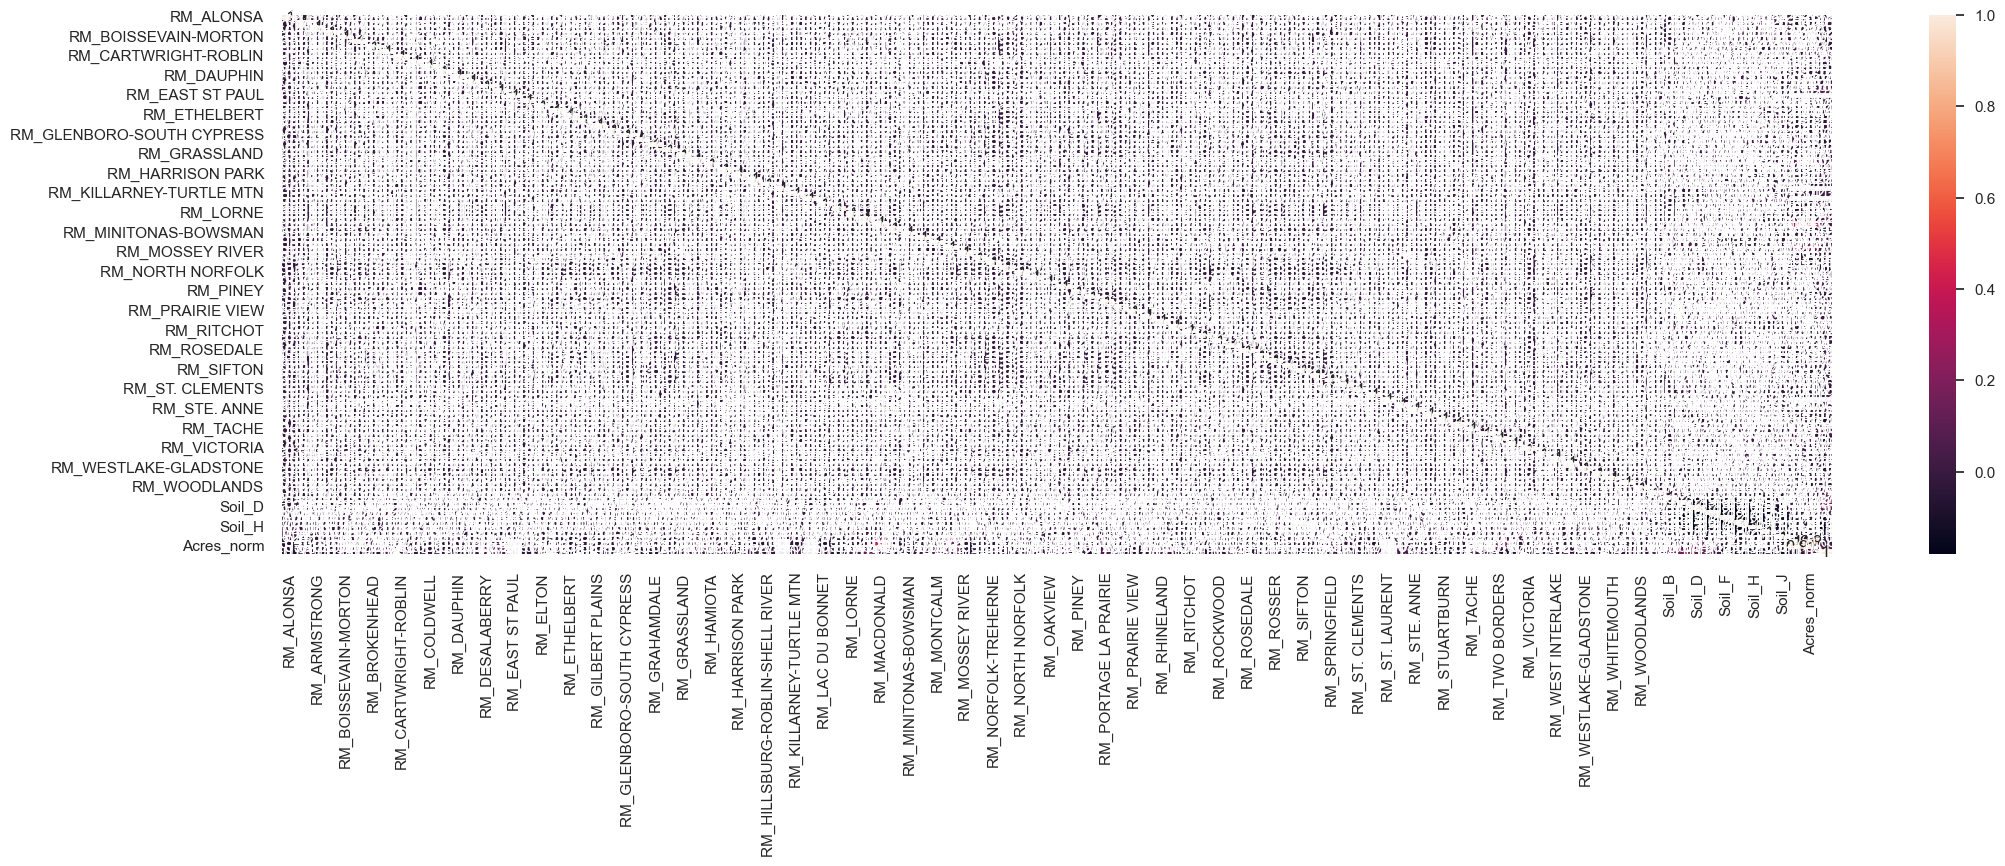

In [118]:
sns.heatmap(df_oats_feature_2_norm.corr(), annot=True)


In [119]:
# Too many features when including RM  - going to consolidate RM by frequency of each RM in the dataset

In [120]:
df_rm=df_oats_feature.groupby(['RM'])['Soil'].count().reset_index()
df_rm.head()

RM  Soil
0         ALEXANDER   111
1            ALONSA   100
2            ARGYLE   149
3         ARMSTRONG    78
4  BIFROST-RIVERTON   160

[Text(0.5, 1.0, 'RM Frequency Bins')]

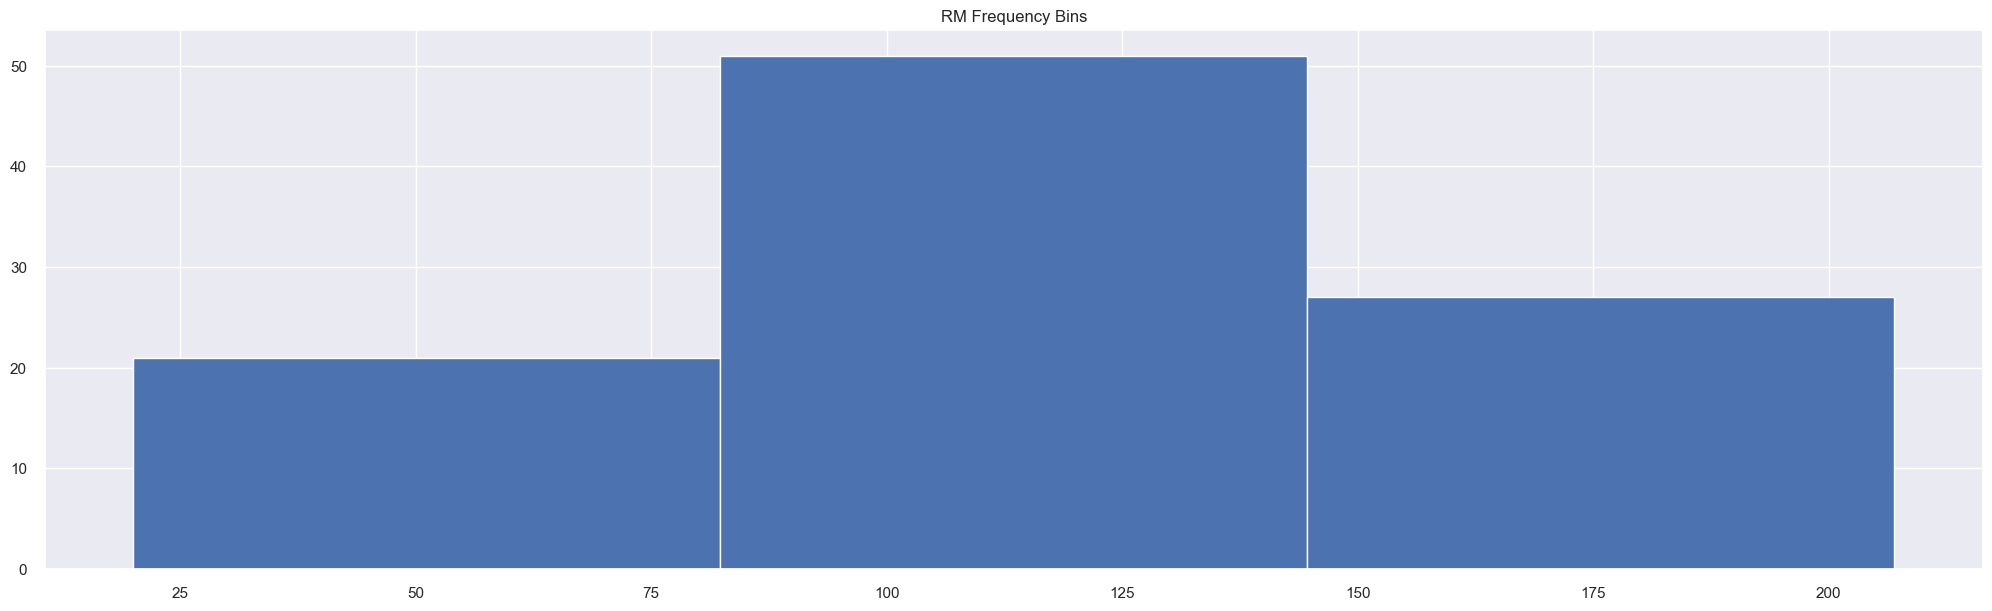

In [121]:
df_oats_feature.groupby(['RM'])['Soil'].count().hist(bins=3).set(title='RM Frequency Bins')

In [122]:
# 1 for low frequency
# 2 for middle frequency
# 3 for high frequency


df_rm['RM_Freq'] = np.where(df_rm['Soil']<80,1,np.where(df_rm['Soil']<144,2,3))
df_rm

RM  Soil  RM_Freq
0                      ALEXANDER   111        2
1                         ALONSA   100        2
2                         ARGYLE   149        3
3                      ARMSTRONG    78        1
4               BIFROST-RIVERTON   160        3
5              BOISSEVAIN-MORTON   106        2
6                 BRENDA-WASKADA   120        2
7                     BROKENHEAD   116        2
8                        CARTIER    92        2
9              CARTWRIGHT-ROBLIN   125        2
10          CLANWILLIAM-ERICKSON    77        1
11                      COLDWELL    70        1
12                    CORNWALLIS   133        2
13                       DAUPHIN   148        3
14          DELORAINE-WINCHESTER    88        2
15                   DESALABERRY   108        2
16                      DUFFERIN   161        3
17                  EAST ST PAUL    20        1
18                 ELLICE-ARCHIE   114        2
19                         ELTON    86        2
20              EMERSON-FRANKLIN   124        2
21                     ETHELBERT   110        2
22                        FISHER   119        2
23                GILBERT PLAINS   143        2
24                         GIMLI    90        2
25        GLENBORO-SOUTH CYPRESS   175        3
26            GLENELLA-LANSDOWNE   137        2
27                    GRAHAMDALE    97        2
28                     GRANDVIEW   135        2
29                     GRASSLAND   151        3
30                          GREY   123        2
31                       HAMIOTA    52        1
32                       HANOVER   124        2
33                 HARRISON PARK   156        3
34                    HEADINGLEY    43        1
35  HILLSBURG-ROBLIN-SHELL RIVER   163        3
36                        KELSEY    91        2
37          KILLARNEY-TURTLE MTN    75        1
38                  LA BROQUERIE    52        1
39                 LAC DU BONNET   128        2
40                     LAKESHORE   125        2
41                         LORNE   130        2
42                        LOUISE   124        2
43                     MACDONALD    71        1
44                      MCCREARY   161        3
45             MINITONAS-BOWSMAN   142        2
46                  MINTO-ODANAH    79        1
47                      MONTCALM    69        1
48                        MORRIS    97        2
49                  MOSSEY RIVER    99        2
50                      MOUNTAIN   119        2
51              NORFOLK-TREHERNE   185        3
52        NORTH CYPRESS-LANGFORD   207        3
53                 NORTH NORFOLK   159        3
54              OAKLAND-WAWANESA   161        3
55                       OAKVIEW    80        2
56                       PEMBINA   108        2
57                         PINEY   113        2
58                     PIPESTONE   150        3
59            PORTAGE LA PRAIRIE   201        3
60                 PRAIRIE LAKES   131        2
61                  PRAIRIE VIEW   184        3
62                      REYNOLDS    98        2
63                     RHINELAND    79        1
64          RIDING MOUNTAIN WEST   113        2
65                       RITCHOT    68        1
66                     RIVERDALE   150        3
67                      ROCKWOOD   173        3
68                        ROLAND    88        2
69                      ROSEDALE   153        3
70                      ROSSBURN   135        2
71                        ROSSER   143        2
72             RUSSELL-BINSCARTH   126        2
73                        SIFTON   111        2
74               SOURIS-GLENWOOD   175        3
75                   SPRINGFIELD   129        2
76                   ST. ANDREWS   130        2
77                  ST. CLEMENTS    88        2
78            ST. FRANCIS XAVIER   103        2
79                   ST. LAURENT    22        1
80                       STANLEY   131        2
81                     STE. ANNE    71        1
82                     STE. ROSE    99        

In [123]:
# Merge with main feature dataframe
df_oats_feature_3=df_oats_feature.merge(df_rm[['RM','RM_Freq']],how='inner',on=['RM']).drop(columns=['RM'])
df_oats_feature_3 = pd.get_dummies(df_oats_feature_3, columns=['Soil','RM_Freq'], drop_first=False)
df_oats_feature_3.head()

Farms   Acres  Yield_bushels  Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  \
0    5.0   760.0          185.9   False   False   False   False    True   
1    6.0  1057.0          178.3   False    True   False   False   False   
2    7.0  1382.0          158.8   False   False    True   False   False   
3   18.0  2736.0          157.0   False   False   False    True   False   
4    7.0  1061.0          148.1   False   False    True   False   False   

   Soil_F  Soil_G  Soil_H  Soil_I  Soil_J  RM_Freq_1  RM_Freq_2  RM_Freq_3  
0   False   False   False   False   False      False       True      False  
1   False   False   False   False   False      False       True      False  
2   False   False   False   False   False      False       True      False  
3   False   False   False   False   False      False       True      False  
4   False   False   False   False   False      False       True      False

<b> Normalize


In [124]:
# Need to normalize contrinuous features
df_oats_feature_3['Farms_norm'] =  normalize(df_oats_feature_3,'Farms')     
df_oats_feature_3['Acres_norm'] =  normalize(df_oats_feature_3,'Acres')     
df_oats_feature_3['Yield_bushels_norm'] =  normalize(df_oats_feature_3,'Yield_bushels')   

df_oats_feature_3_norm=df_oats_feature_3.drop(columns=['Farms',
'Acres',
'Yield_bushels'
])
df_oats_feature_3_norm.head()

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
0   False   False   False   False    True   False   False   False   False   
1   False    True   False   False   False   False   False   False   False   
2   False   False    True   False   False   False   False   False   False   
3   False   False   False    True   False   False   False   False   False   
4   False   False    True   False   False   False   False   False   False   

   Soil_J  RM_Freq_1  RM_Freq_2  RM_Freq_3  Farms_norm  Acres_norm  \
0   False      False       True      False    0.015504    0.009201   
1   False      False       True      False    0.023256    0.019711   
2   False      False       True      False    0.031008    0.031211   
3   False      False       True      False    0.116279    0.079125   
4   False      False       True      False    0.031008    0.019852   

   Yield_bushels_norm  
0            1.000000  
1            0.957542  
2            0.848603  
3            0.838547  
4            0.788827

In [127]:
df_oats_feature_3_norm[df_oats_feature_3_norm['Yield_bushels_norm'].isnull()==True].head()

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
89        0       0       0       0       1       0       0       0       0   
90        0       0       0       0       1       0       0       0       0   
91        0       0       0       0       1       0       0       0       0   
201       0       0       1       0       0       0       0       0       0   
202       0       0       0       0       0       0       0       0       0   

     Soil_J  RM_Freq_1  RM_Freq_2  RM_Freq_3  Farms_norm  Acres_norm  \
89        0          0          1          0         NaN         NaN   
90        0          0          1          0         NaN         NaN   
91        0          0          1          0         NaN         NaN   
201       0          0          0          1         NaN         NaN   
202       1          0          0          1         NaN         NaN   

     Yield_bushels_norm  
89                  NaN  
90                  NaN  
91                  NaN  
201                 NaN  
202                 NaN

<Axes: >

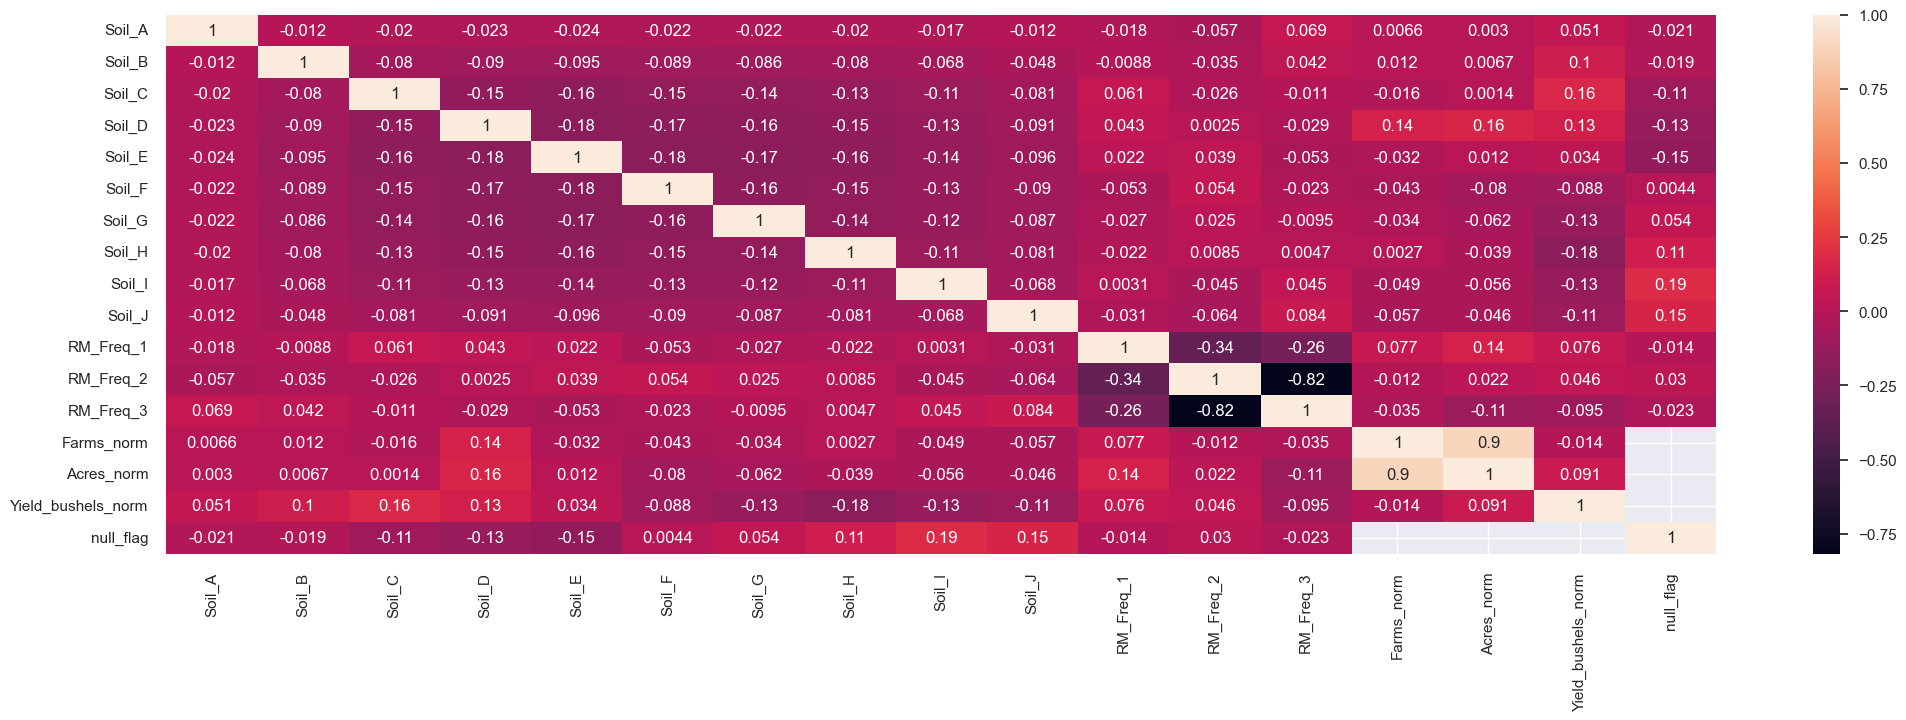

In [129]:
# Correlation heatmap
df_oats_feature_3_norm=df_oats_feature_3_norm*1
# Add flag for nulls
df_oats_feature_3_norm['null_flag']=np.where(df_oats_feature_3_norm['Yield_bushels_norm'].isnull()==True,1,0)
sns.heatmap(df_oats_feature_3_norm.corr(), annot=True)


In [126]:
# <p> Not a ton of strong correlation that is helpful, farm size and acres being correlated makes sense

In [ ]:
# Initial 

C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

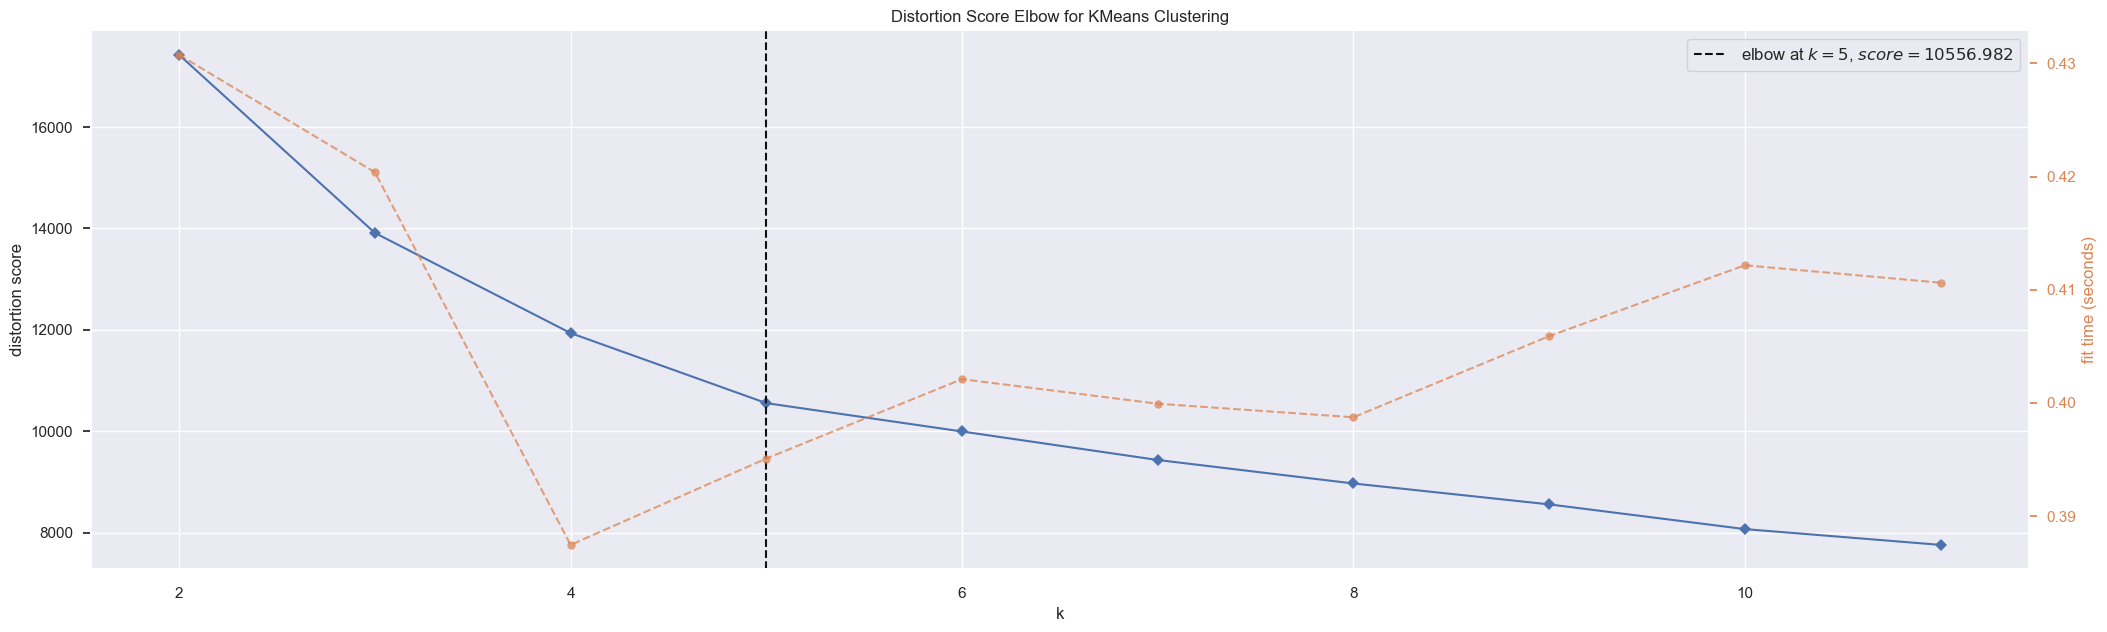

5


C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5)

In [137]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
# Converting data to a dataframe to view properly

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_oats_feature_3_norm.fillna(0))        # Fit the data to the visualizer
visualizer.show()  
# optimal cluster value
optimal_value = visualizer.elbow_value_
print(optimal_value)
# Performing K-means clustering analysis using optimal clusters
kmeans_optimal = KMeans(n_clusters=optimal_value)
# Determining cluster of each observation

kmeans_optimal.fit(df_oats_feature_3_norm.fillna(0))





In [138]:
df_oats_feature_3_norm['cluster'] = kmeans_optimal.labels_

# Printing first 5 observations with their cluster
(df_oats_feature_3_norm.head())

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
0       0       0       0       0       1       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       0       1       0       0       0       0       0       0   
3       0       0       0       1       0       0       0       0       0   
4       0       0       1       0       0       0       0       0       0   

   Soil_J  RM_Freq_1  RM_Freq_2  RM_Freq_3  Farms_norm  Acres_norm  \
0       0          0          1          0    0.015504    0.009201   
1       0          0          1          0    0.023256    0.019711   
2       0          0          1          0    0.031008    0.031211   
3       0          0          1          0    0.116279    0.079125   
4       0          0          1          0    0.031008    0.019852   

   Yield_bushels_norm  null_flag  cluster  
0            1.000000          0        4  
1            0.957542          0        4  
2            0.848603          0        4  
3            0.838547          0        4  
4            0.788827          0        4

In [139]:
df_oats_feature_3_norm['cluster'].value_counts()

cluster
1    3454
4    2517
0    2461
2    2016
3    1151
Name: count, dtype: int64

In [140]:
df_oats_feature_year_2=df_oats_feature_year.merge(df_rm[['RM','RM_Freq']],how='inner',on=['RM']).drop(columns=['RM'])
df_oats_feature_year_2 = pd.get_dummies(df_oats_feature_year_2, columns=['Soil','Year','RM_Freq'])
df_oats_feature_year_2.head()

Farms   Acres  Yield_bushels  Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  \
0    5.0   760.0          185.9   False   False   False   False    True   
1    6.0  1057.0          178.3   False    True   False   False   False   
2    7.0  1382.0          158.8   False   False    True   False   False   
3   18.0  2736.0          157.0   False   False   False    True   False   
4    7.0  1061.0          148.1   False   False    True   False   False   

   Soil_F  Soil_G  Soil_H  Soil_I  Soil_J  Year_2000  Year_2001  Year_2002  \
0   False   False   False   False   False      False      False      False   
1   False   False   False   False   False      False      False      False   
2   False   False   False   False   False      False      False      False   
3   False   False   False   False   False      False      False      False   
4   False   False   False   False   False      False      False      False   

   Year_2003  Year_2004  Year_2005  Year_2006  Year_2007  Year_2008  \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

   Year_2009  Year_2010  Year_2011  Year_2012  Year_2013  Year_2014  \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False       True      False   

   Year_2015  Year_2016  Year_2017  Year_2018  Year_2019  Year_2020  \
0      False      False       True      False      False      False   
1      False      False       True      False      False      False   
2      False      False       True      False      False      False   
3      False      False       True      False      False      False   
4      False      False      False      False      False      False   

   Year_2021  Year_2022  RM_Freq_1  RM_Freq_2  RM_Freq_3  
0      False      False      False       True      False  
1      False      False      False       True      False  
2      False      False      False       True      False  
3      False      False      False       True      False  
4      False      False      False       True      False

In [141]:
df_oats_feature_year_2['Farms_norm'] =  normalize(df_oats_feature_year_2,'Farms')     
df_oats_feature_year_2['Acres_norm'] =  normalize(df_oats_feature_year_2,'Acres')     
df_oats_feature_year_2['Yield_bushels_norm'] =  normalize(df_oats_feature_year_2,'Yield_bushels')   

df_oats_feature_year_2_norm=df_oats_feature_year_2.drop(columns=['Farms',
'Acres',
'Yield_bushels'
])
df_oats_feature_year_2_norm.head()

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
0   False   False   False   False    True   False   False   False   False   
1   False    True   False   False   False   False   False   False   False   
2   False   False    True   False   False   False   False   False   False   
3   False   False   False    True   False   False   False   False   False   
4   False   False    True   False   False   False   False   False   False   

   Soil_J  Year_2000  Year_2001  Year_2002  Year_2003  Year_2004  Year_2005  \
0   False      False      False      False      False      False      False   
1   False      False      False      False      False      False      False   
2   False      False      False      False      False      False      False   
3   False      False      False      False      False      False      False   
4   False      False      False      False      False      False      False   

   Year_2006  Year_2007  Year_2008  Year_2009  Year_2010  Year_2011  \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

   Year_2012  Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  \
0      False      False      False      False      False       True   
1      False      False      False      False      False       True   
2      False      False      False      False      False       True   
3      False      False      False      False      False       True   
4      False       True      False      False      False      False   

   Year_2018  Year_2019  Year_2020  Year_2021  Year_2022  RM_Freq_1  \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

   RM_Freq_2  RM_Freq_3  Farms_norm  Acres_norm  Yield_bushels_norm  
0       True      False    0.015504    0.009201            1.000000  
1       True      False    0.023256    0.019711            0.957542  
2       True      False    0.031008    0.031211            0.848603  
3       True      False    0.116279    0.079125            0.838547  
4       True      False    0.031008    0.019852            0.788827

In [143]:
df_oats_feature_year_2_norm = df_oats_feature_year_2_norm*1 # multiply by 1 to convert boolean to integer
df_oats_feature_year_2_norm['null_flag']=np.where(df_oats_feature_year_2_norm['Yield_bushels_norm'].isnull()==True,1,0)

df_oats_feature_year_2_norm.head()

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
0       0       0       0       0       1       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       0       1       0       0       0       0       0       0   
3       0       0       0       1       0       0       0       0       0   
4       0       0       1       0       0       0       0       0       0   

   Soil_J  Year_2000  Year_2001  Year_2002  Year_2003  Year_2004  Year_2005  \
0       0          0          0          0          0          0          0   
1       0          0          0          0          0          0          0   
2       0          0          0          0          0          0          0   
3       0          0          0          0          0          0          0   
4       0          0          0          0          0          0          0   

   Year_2006  Year_2007  Year_2008  Year_2009  Year_2010  Year_2011  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   Year_2012  Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          1   
2          0          0          0          0          0          1   
3          0          0          0          0          0          1   
4          0          1          0          0          0          0   

   Year_2018  Year_2019  Year_2020  Year_2021  Year_2022  RM_Freq_1  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   RM_Freq_2  RM_Freq_3  Farms_norm  Acres_norm  Yield_bushels_norm  null_flag  
0          1          0    0.015504    0.009201            1.000000          0  
1          1          0    0.023256    0.019711            0.957542          0  
2          1          0    0.031008    0.031211            0.848603          0  
3          1          0    0.116279    0.079125            0.838547          0  
4          1          0    0.031008    0.019852            0.788827          0

In [144]:
# sns.heatmap(df_oats_feature_year_2.corr(), annot=True)
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(round(df_oats_feature_year_2_norm.corr(),1), annot=True, linewidths=.5, ax=ax)

<Axes: >

In [ ]:
# No overall trend with null flag

In [146]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
# Converting data to a dataframe to view properly

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(df_oats_feature_year_2_norm.fillna(0))        # Fit the data to the visualizer
visualizer.show()  
# optimal cluster value
optimal_value = visualizer.elbow_value_
print(optimal_value)
# Performing K-means clustering analysis using optimal clusters
kmeans_optimal = KMeans(n_clusters=optimal_value)
# Determining cluster of each observation

kmeans_optimal.fit(df_oats_feature_year_2_norm.fillna(0))



C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

3


C:\Users\giacr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [147]:
df_oats_feature_year_2_norm['cluster'] = kmeans_optimal.labels_

# Printing first 5 observations with their cluster
(df_oats_feature_year_2_norm.head())

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
0       0       0       0       0       1       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       0       1       0       0       0       0       0       0   
3       0       0       0       1       0       0       0       0       0   
4       0       0       1       0       0       0       0       0       0   

   Soil_J  Year_2000  Year_2001  Year_2002  Year_2003  Year_2004  Year_2005  \
0       0          0          0          0          0          0          0   
1       0          0          0          0          0          0          0   
2       0          0          0          0          0          0          0   
3       0          0          0          0          0          0          0   
4       0          0          0          0          0          0          0   

   Year_2006  Year_2007  Year_2008  Year_2009  Year_2010  Year_2011  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   Year_2012  Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          1   
2          0          0          0          0          0          1   
3          0          0          0          0          0          1   
4          0          1          0          0          0          0   

   Year_2018  Year_2019  Year_2020  Year_2021  Year_2022  RM_Freq_1  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   RM_Freq_2  RM_Freq_3  Farms_norm  Acres_norm  Yield_bushels_norm  \
0          1          0    0.015504    0.009201            1.000000   
1          1          0    0.023256    0.019711            0.957542   
2          1          0    0.031008    0.031211            0.848603   
3          1          0    0.116279    0.079125            0.838547   
4          1          0    0.031008    0.019852            0.788827   

   null_flag  cluster  
0          0        2  
1          0        2  
2          0        2  
3          0        2  
4          0        2

In [156]:
df_oats_feature_year_2_norm['cluster'].value_counts()

cluster
0    4477
1    4079
2    3043
Name: count, dtype: int64

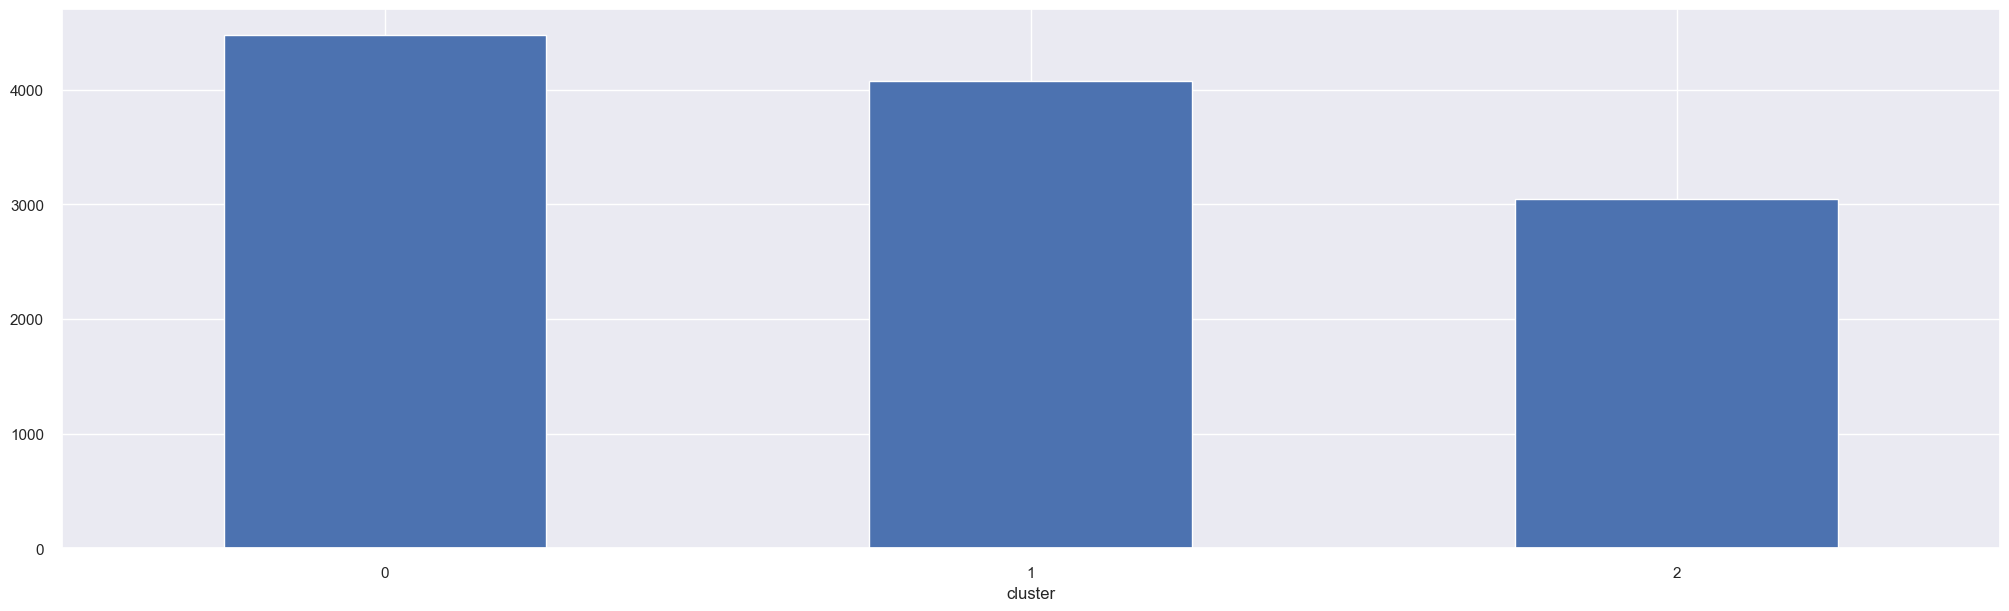

In [148]:
df_oats_feature_year_2_norm['cluster'].value_counts().plot
ax = df_oats_feature_year_2_norm['cluster'].value_counts().plot.bar(x='lab', y='val', rot=0)


In [149]:
df_oats_feature_year_2_output = pd.merge(df_oats_feature_year_2_norm, df_oats_feature_year_2[['Farms', 'Acres', 'Yield_bushels']], left_index=True, right_index=True).drop(columns=['Farms_norm', 'Acres_norm', 'Yield_bushels_norm'])
df_oats_feature_year_2_output.head()

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
0       0       0       0       0       1       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       0       1       0       0       0       0       0       0   
3       0       0       0       1       0       0       0       0       0   
4       0       0       1       0       0       0       0       0       0   

   Soil_J  Year_2000  Year_2001  Year_2002  Year_2003  Year_2004  Year_2005  \
0       0          0          0          0          0          0          0   
1       0          0          0          0          0          0          0   
2       0          0          0          0          0          0          0   
3       0          0          0          0          0          0          0   
4       0          0          0          0          0          0          0   

   Year_2006  Year_2007  Year_2008  Year_2009  Year_2010  Year_2011  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   Year_2012  Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          1   
2          0          0          0          0          0          1   
3          0          0          0          0          0          1   
4          0          1          0          0          0          0   

   Year_2018  Year_2019  Year_2020  Year_2021  Year_2022  RM_Freq_1  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   RM_Freq_2  RM_Freq_3  null_flag  cluster  Farms   Acres  Yield_bushels  
0          1          0          0        2    5.0   760.0          185.9  
1          1          0          0        2    6.0  1057.0          178.3  
2          1          0          0        2    7.0  1382.0          158.8  
3          1          0          0        2   18.0  2736.0          157.0  
4          1          0          0        2    7.0  1061.0          148.1

In [150]:
df_oats_cluster_0 = df_oats_feature_year_2_output[df_oats_feature_year_2_output['cluster'] == 0]
df_oats_cluster_1 = df_oats_feature_year_2_output[df_oats_feature_year_2_output['cluster'] == 1]

df_oats_cluster_2 = df_oats_feature_year_2_output[df_oats_feature_year_2_output['cluster'] == 2]

df_oats_cluster_0.head()

Soil_A  Soil_B  Soil_C  Soil_D  Soil_E  Soil_F  Soil_G  Soil_H  Soil_I  \
92       0       0       1       0       0       0       0       0       0   
93       0       0       0       1       0       0       0       0       0   
94       0       0       0       0       1       0       0       0       0   
95       0       0       0       0       0       1       0       0       0   
96       0       0       0       1       0       0       0       0       0   

    Soil_J  Year_2000  Year_2001  Year_2002  Year_2003  Year_2004  Year_2005  \
92       0          0          0          0          0          0          0   
93       0          0          0          0          0          0          0   
94       0          0          0          0          0          0          0   
95       0          0          0          0          0          0          0   
96       0          0          0          0          0          0          0   

    Year_2006  Year_2007  Year_2008  Year_2009  Year_2010  Year_2011  \
92          0          0          0          0          0          0   
93          0          0          0          0          0          0   
94          0          0          0          0          0          0   
95          0          0          0          0          0          0   
96          0          0          0          0          0          0   

    Year_2012  Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  \
92          0          0          0          0          0          1   
93          0          0          0          0          0          1   
94          0          0          0          0          0          1   
95          0          0          0          0          0          1   
96          0          0          0          0          1          0   

    Year_2018  Year_2019  Year_2020  Year_2021  Year_2022  RM_Freq_1  \
92          0          0          0          0          0          0   
93          0          0          0          0          0          0   
94          0          0          0          0          0          0   
95          0          0          0          0          0          0   
96          0          0          0          0          0          0   

    RM_Freq_2  RM_Freq_3  null_flag  cluster  Farms   Acres  Yield_bushels  
92          0          1          0        0    3.0   511.0          179.1  
93          0          1          0        0   10.0  2515.0          156.5  
94          0          1          0        0   17.0  2248.0          147.6  
95          0          1          0        0    7.0   700.0          141.4  
96          0          1          0        0   15.0  2159.0          139.0

Year
2000     86.602372
2001     70.680342
2002     69.202013
2003     85.386691
2004     98.878571
2005     54.584112
2006     81.698507
2007     87.498667
2008    101.040076
2009    102.915054
2010     79.208287
2011     73.169930
2012     82.676684
2013    110.700000
2014     93.770909
2015    102.628155
2016    110.805096
2017    129.070526
2018    108.060510
2019     99.324229
2020    114.397984
2021     68.095851
2022    117.954331
Name: Yield_bushels, dtype: float64

In [151]:
df_oats_feature_year_2_norm.sum()

Soil_A                   35.000000
Soil_B                  528.000000
Soil_C                 1374.000000
Soil_D                 1686.000000
Soil_E                 1853.000000
Soil_F                 1641.000000
Soil_G                 1563.000000
Soil_H                 1364.000000
Soil_I                 1017.000000
Soil_J                  538.000000
Year_2000               544.000000
Year_2001               525.000000
Year_2002               554.000000
Year_2003               560.000000
Year_2004               524.000000
Year_2005               480.000000
Year_2006               531.000000
Year_2007               541.000000
Year_2008               538.000000
Year_2009               501.000000
Year_2010               474.000000
Year_2011               416.000000
Year_2012               494.000000
Year_2013               483.000000
Year_2014               461.000000
Year_2015               499.000000
Year_2016               468.000000
Year_2017               459.000000
Year_2018           

In [152]:
df_oats_cluster_0.describe().T[]

count         mean          std    min      25%     50%  \
Soil_A         4477.0     0.007818     0.088082    0.0    0.000     0.0   
Soil_B         4477.0     0.056511     0.230932    0.0    0.000     0.0   
Soil_C         4477.0     0.114139     0.318015    0.0    0.000     0.0   
Soil_D         4477.0     0.132455     0.339022    0.0    0.000     0.0   
Soil_E         4477.0     0.135135     0.341906    0.0    0.000     0.0   
Soil_F         4477.0     0.131338     0.337807    0.0    0.000     0.0   
Soil_G         4477.0     0.130668     0.337074    0.0    0.000     0.0   
Soil_H         4477.0     0.119500     0.324412    0.0    0.000     0.0   
Soil_I         4477.0     0.103641     0.304828    0.0    0.000     0.0   
Soil_J         4477.0     0.068796     0.253135    0.0    0.000     0.0   
Year_2000      4477.0     0.046236     0.210020    0.0    0.000     0.0   
Year_2001      4477.0     0.044896     0.207099    0.0    0.000     0.0   
Year_2002      4477.0     0.046460     0.210502    0.0    0.000     0.0   
Year_2003      4477.0     0.045566     0.208566    0.0    0.000     0.0   
Year_2004      4477.0     0.046236     0.210020    0.0    0.000     0.0   
Year_2005      4477.0     0.044449     0.206114    0.0    0.000     0.0   
Year_2006      4477.0     0.045566     0.208566    0.0    0.000     0.0   
Year_2007      4477.0     0.047130     0.211940    0.0    0.000     0.0   
Year_2008      4477.0     0.044449     0.206114    0.0    0.000     0.0   
Year_2009      4477.0     0.043109     0.203126    0.0    0.000     0.0   
Year_2010      4477.0     0.041099     0.198541    0.0    0.000     0.0   
Year_2011      4477.0     0.035962     0.186215    0.0    0.000     0.0   
Year_2012      4477.0     0.043109     0.203126    0.0    0.000     0.0   
Year_2013      4477.0     0.041099     0.198541    0.0    0.000     0.0   
Year_2014      4477.0     0.039759     0.195414    0.0    0.000     0.0   
Year_2015      4477.0     0.042662     0.202118    0.0    0.000     0.0   
Year_2016      4477.0     0.040429     0.196985    0.0    0.000     0.0   
Year_2017      4477.0     0.041099     0.198541    0.0    0.000     0.0   
Year_2018      4477.0     0.040205     0.196463    0.0    0.000     0.0   
Year_2019      4477.0     0.045119     0.207589    0.0    0.000     0.0   
Year_2020      4477.0     0.046683     0.210983    0.0    0.000     0.0   
Year_2021      4477.0     0.044673     0.206607    0.0    0.000     0.0   
Year_2022      4477.0     0.044003     0.205124    0.0    0.000     0.0   
RM_Freq_1      4477.0     0.000000     0.000000    0.0    0.000     0.0   
RM_Freq_2      4477.0     0.000000     0.000000    0.0    0.000     0.0   
RM_Freq_3      4477.0     1.000000     0.000000    1.0    1.000     1.0   
null_flag      4477.0     0.549698     0.497580    0.0    0.000     1.0   
cluster        4477.0     0.000000     0.000000    0.0    0.000     0.0   
Farms          2016.0    13.113095     9.136251    3.0    7.000    10.0   
Acres          2016.0  1769.396925  1612.131952  500.0  742.750  1179.5   
Yield_bushels  2016.0    88.331448    26.344522   13.5   69.875    88.3   

                    75%      max  
Soil_A            0.000      1.0  
Soil_B            0.000      1.0  
Soil_C            0.000      1.0  
Soil_D            0.000      1.0  
Soil_E            0.000      1.0  
Soil_F            0.000      1.0  
Soil_G            0.000      1.0  
Soil_H            0.000      1.0  
Soil_I            0.000      1.0  
Soil_J            0.000      1.0  
Year_2000         0.000      1.0  
Year_2001         0.000      1.0  
Year_2002         0.000      1.0  
Year_2003         0.000      1.0  
Year_2004         0.000      1.0  
Year_2005         0.000      1.0  
Year_2006         0.000      1.0  
Year_2007         0.000      1.0  
Year_2008         0.000      1.0  
Year_2009         0.000      1.0  
Year_2010         0.000      1.0  
Year_2011         0.000      1.0  
Year_2012         0.000      1.0  
Year_2013         0.000  

In [175]:
# sns.heatmap(df_oats_feature_year_2.corr(), annot=True)
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(round(df_oats_feature_year_2_norm[df_oats_feature_year_2_norm['cluster'] == 0].corr(),1), annot=True, linewidths=.5, ax=ax)
# sns.heatmap(round(df_oats_cluster_0.corr(),1), annot=True, linewidths=.5, ax=ax)

<Axes: >

In [ ]:
# smaller  yields in general but especially in 2021, all RM label 3
# soil 
# half null yields similar to dataset

In [ ]:
# Characteristics - All RM label 3

In [155]:
df_oats_cluster_1.describe().T

count      mean       std  min  25%  50%  75%  max
Soil_A         4079.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Soil_B         4079.0  0.029909  0.170358  0.0  0.0  0.0  0.0  1.0
Soil_C         4079.0  0.071586  0.257833  0.0  0.0  0.0  0.0  1.0
Soil_D         4079.0  0.101495  0.302021  0.0  0.0  0.0  0.0  1.0
Soil_E         4079.0  0.121108  0.326293  0.0  0.0  0.0  0.0  1.0
Soil_F         4079.0  0.157392  0.364214  0.0  0.0  0.0  0.0  1.0
Soil_G         4079.0  0.173082  0.378364  0.0  0.0  0.0  0.0  1.0
Soil_H         4079.0  0.166708  0.372760  0.0  0.0  0.0  0.0  1.0
Soil_I         4079.0  0.126502  0.332455  0.0  0.0  0.0  0.0  1.0
Soil_J         4079.0  0.052219  0.222495  0.0  0.0  0.0  0.0  1.0
Year_2000      4079.0  0.045109  0.207569  0.0  0.0  0.0  0.0  1.0
Year_2001      4079.0  0.045354  0.208105  0.0  0.0  0.0  0.0  1.0
Year_2002      4079.0  0.040206  0.196466  0.0  0.0  0.0  0.0  1.0
Year_2003      4079.0  0.045845  0.209174  0.0  0.0  0.0  0.0  1.0
Year_2004      4079.0  0.046090  0.209705  0.0  0.0  0.0  0.0  1.0
Year_2005      4079.0  0.038245  0.191810  0.0  0.0  0.0  0.0  1.0
Year_2006      4079.0  0.041432  0.199311  0.0  0.0  0.0  0.0  1.0
Year_2007      4079.0  0.039225  0.194154  0.0  0.0  0.0  0.0  1.0
Year_2008      4079.0  0.044619  0.206491  0.0  0.0  0.0  0.0  1.0
Year_2009      4079.0  0.047806  0.213381  0.0  0.0  0.0  0.0  1.0
Year_2010      4079.0  0.043393  0.203765  0.0  0.0  0.0  0.0  1.0
Year_2011      4079.0  0.038000  0.191218  0.0  0.0  0.0  0.0  1.0
Year_2012      4079.0  0.044619  0.206491  0.0  0.0  0.0  0.0  1.0
Year_2013      4079.0  0.048541  0.214933  0.0  0.0  0.0  0.0  1.0
Year_2014      4079.0  0.044619  0.206491  0.0  0.0  0.0  0.0  1.0
Year_2015      4079.0  0.045109  0.207569  0.0  0.0  0.0  0.0  1.0
Year_2016      4079.0  0.047561  0.212861  0.0  0.0  0.0  0.0  1.0
Year_2017      4079.0  0.038735  0.192986  0.0  0.0  0.0  0.0  1.0
Year_2018      4079.0  0.045599  0.208640  0.0  0.0  0.0  0.0  1.0
Year_2019      4079.0  0.050012  0.217997  0.0  0.0  0.0  0.0  1.0
Year_2020      4079.0  0.044128  0.205406  0.0  0.0  0.0  0.0  1.0
Year_2021      4079.0  0.043638  0.204314  0.0  0.0  0.0  0.0  1.0
Year_2022      4079.0  0.032116  0.176329  0.0  0.0  0.0  0.0  1.0
RM_Freq_1      4079.0  0.153224  0.360247  0.0  0.0  0.0  0.0  1.0
RM_Freq_2      4079.0  0.846776  0.360247  0.0  1.0  1.0  1.0  1.0
RM_Freq_3      4079.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
null_flag      4079.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
cluster        4079.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
Farms             0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
Acres             0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
Yield_bushels     0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN

<Axes: >

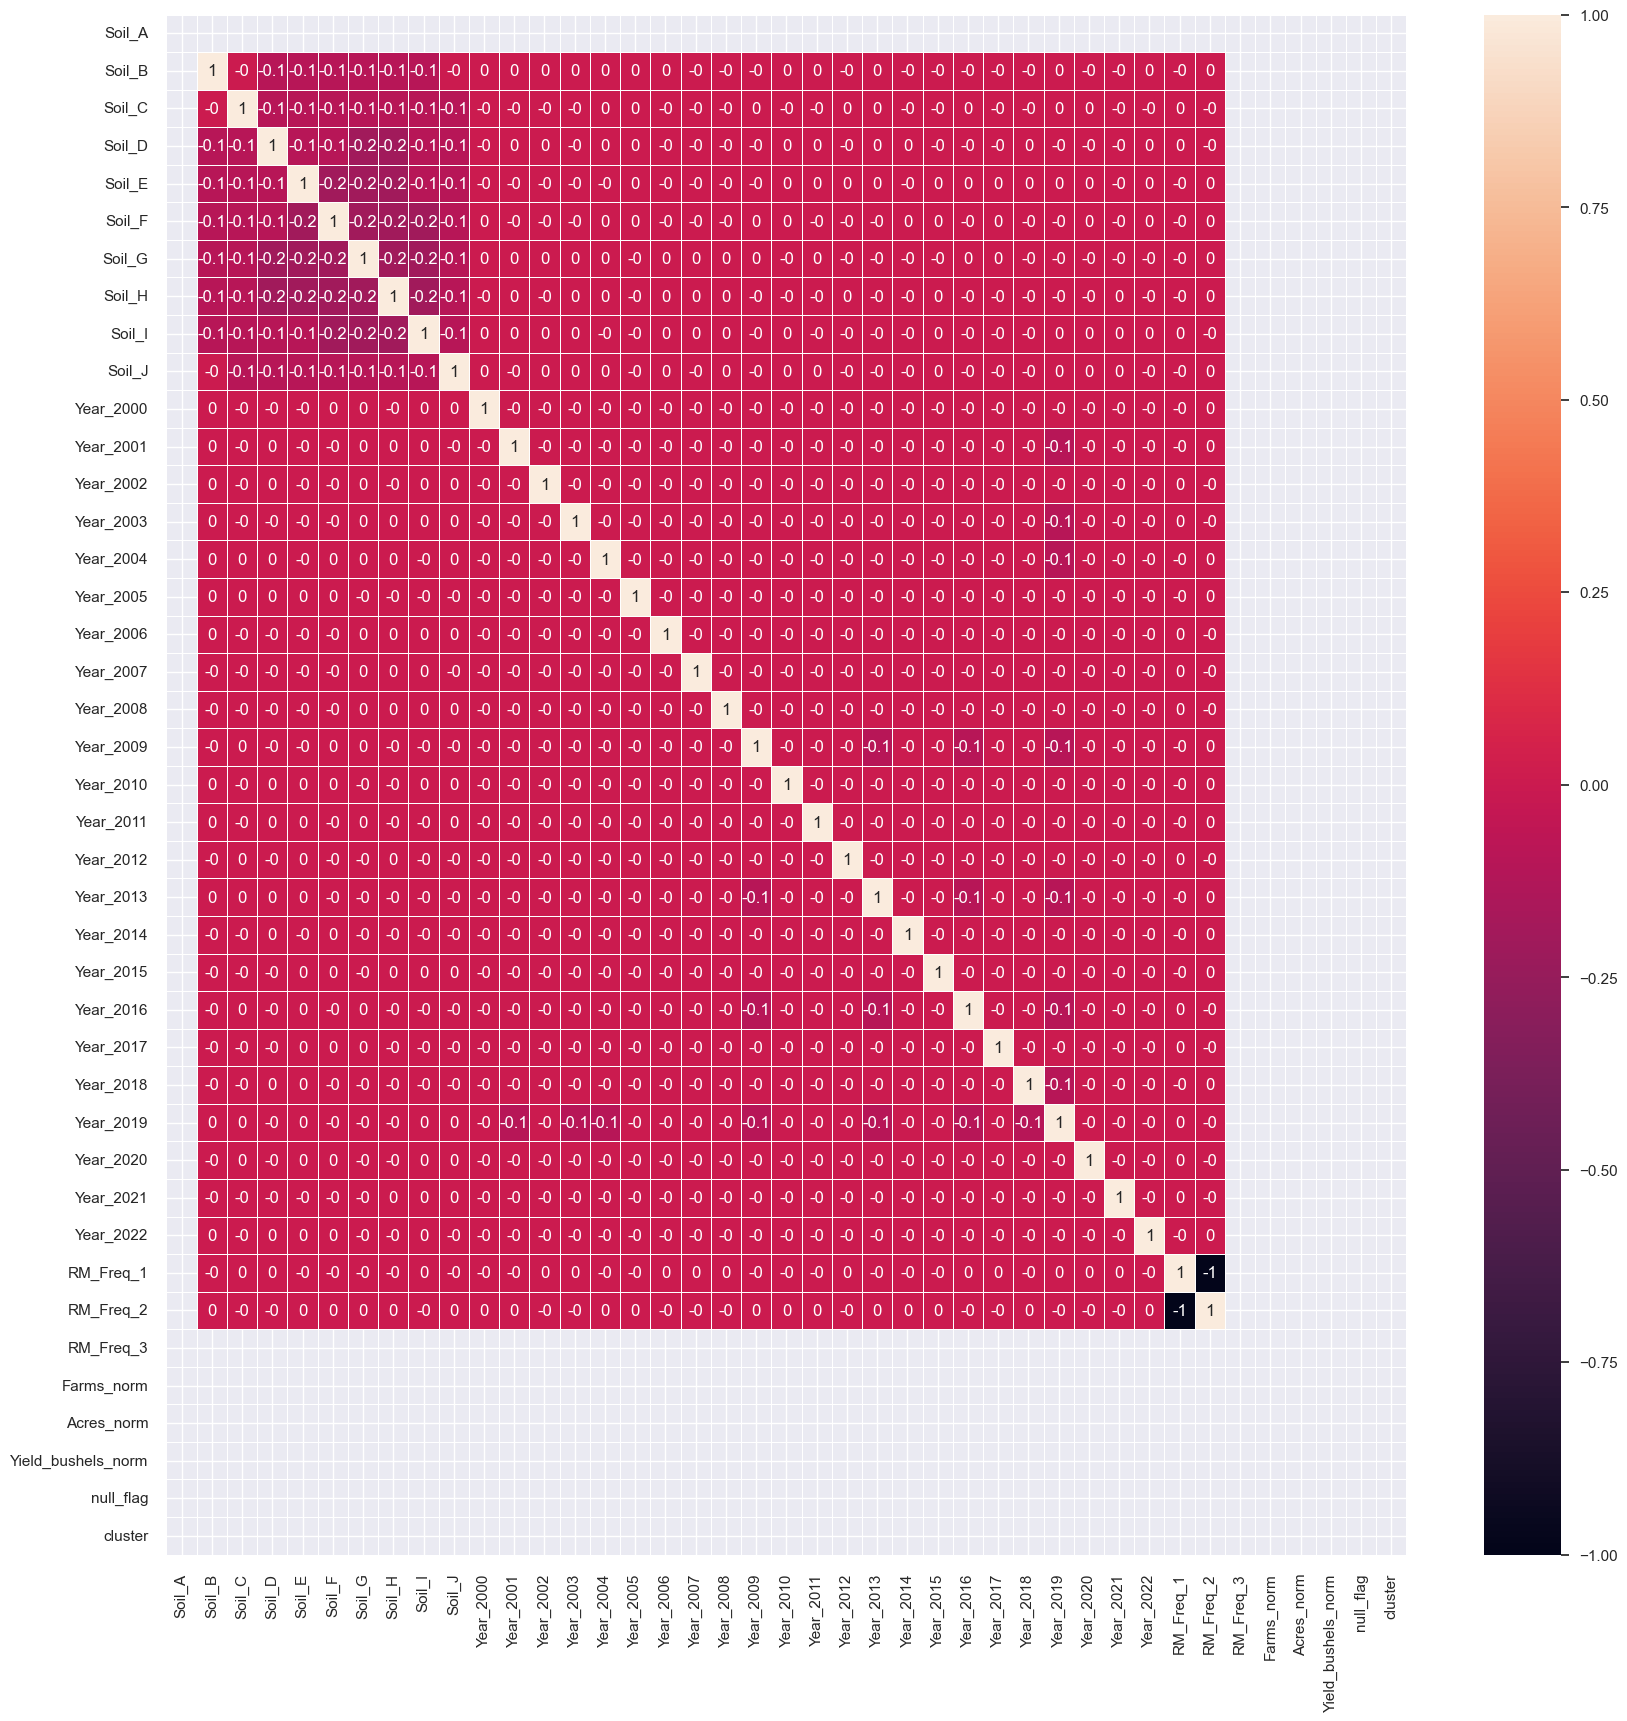

In [157]:
# sns.heatmap(df_oats_feature_year_2.corr(), annot=True)
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(round(df_oats_feature_year_2_norm[df_oats_feature_year_2_norm['cluster'] == 1].corr(),1), annot=True, linewidths=.5, ax=ax)

In [ ]:
# All nulls 0.846776 of these nulls are  in group RM group 2
# Wide range of years and soil typesq

In [158]:
df_oats_cluster_1.sum()

Soil_A              0.0
Soil_B            122.0
Soil_C            292.0
Soil_D            414.0
Soil_E            494.0
Soil_F            642.0
Soil_G            706.0
Soil_H            680.0
Soil_I            516.0
Soil_J            213.0
Year_2000         184.0
Year_2001         185.0
Year_2002         164.0
Year_2003         187.0
Year_2004         188.0
Year_2005         156.0
Year_2006         169.0
Year_2007         160.0
Year_2008         182.0
Year_2009         195.0
Year_2010         177.0
Year_2011         155.0
Year_2012         182.0
Year_2013         198.0
Year_2014         182.0
Year_2015         184.0
Year_2016         194.0
Year_2017         158.0
Year_2018         186.0
Year_2019         204.0
Year_2020         180.0
Year_2021         178.0
Year_2022         131.0
RM_Freq_1         625.0
RM_Freq_2        3454.0
RM_Freq_3           0.0
null_flag        4079.0
cluster          4079.0
Farms               0.0
Acres               0.0
Yield_bushels       0.0
dtype: float64

In [159]:
df_oats_cluster_2.describe().T

count         mean          std    min    25%     50%  \
Soil_A         3043.0     0.000000     0.000000    0.0    0.0     0.0   
Soil_B         3043.0     0.050279     0.218557    0.0    0.0     0.0   
Soil_C         3043.0     0.187644     0.390492    0.0    0.0     0.0   
Soil_D         3043.0     0.223135     0.416417    0.0    0.0     0.0   
Soil_E         3043.0     0.247782     0.431795    0.0    0.0     0.0   
Soil_F         3043.0     0.135064     0.341848    0.0    0.0     0.0   
Soil_G         3043.0     0.089385     0.285346    0.0    0.0     0.0   
Soil_H         3043.0     0.048965     0.215830    0.0    0.0     0.0   
Soil_I         3043.0     0.012159     0.109614    0.0    0.0     0.0   
Soil_J         3043.0     0.005587     0.074547    0.0    0.0     0.0   
Year_2000      3043.0     0.050279     0.218557    0.0    0.0     0.0   
Year_2001      3043.0     0.045679     0.208821    0.0    0.0     0.0   
Year_2002      3043.0     0.059809     0.237172    0.0    0.0     0.0   
Year_2003      3043.0     0.055537     0.229064    0.0    0.0     0.0   
Year_2004      3043.0     0.042392     0.201516    0.0    0.0     0.0   
Year_2005      3043.0     0.041078     0.198503    0.0    0.0     0.0   
Year_2006      3043.0     0.051922     0.221907    0.0    0.0     0.0   
Year_2007      3043.0     0.055866     0.229700    0.0    0.0     0.0   
Year_2008      3043.0     0.051594     0.221242    0.0    0.0     0.0   
Year_2009      3043.0     0.037134     0.189122    0.0    0.0     0.0   
Year_2010      3043.0     0.037134     0.189122    0.0    0.0     0.0   
Year_2011      3043.0     0.032862     0.178305    0.0    0.0     0.0   
Year_2012      3043.0     0.039106     0.193879    0.0    0.0     0.0   
Year_2013      3043.0     0.033191     0.179164    0.0    0.0     0.0   
Year_2014      3043.0     0.033191     0.179164    0.0    0.0     0.0   
Year_2015      3043.0     0.040749     0.197741    0.0    0.0     0.0   
Year_2016      3043.0     0.030562     0.172156    0.0    0.0     0.0   
Year_2017      3043.0     0.038449     0.192309    0.0    0.0     0.0   
Year_2018      3043.0     0.033191     0.179164    0.0    0.0     0.0   
Year_2019      3043.0     0.045021     0.207385    0.0    0.0     0.0   
Year_2020      3043.0     0.048308     0.214451    0.0    0.0     0.0   
Year_2021      3043.0     0.047979     0.213757    0.0    0.0     0.0   
Year_2022      3043.0     0.048965     0.215830    0.0    0.0     0.0   
RM_Freq_1      3043.0     0.172856     0.378185    0.0    0.0     0.0   
RM_Freq_2      3043.0     0.827144     0.378185    0.0    1.0     1.0   
RM_Freq_3      3043.0     0.000000     0.000000    0.0    0.0     0.0   
null_flag      3043.0     0.000000     0.000000    0.0    0.0     0.0   
cluster        3043.0     2.000000     0.000000    2.0    2.0     2.0   
Farms          3043.0    13.904042    11.982235    3.0    7.0    10.0   
Acres          3043.0  2296.884719  2801.883274  500.0  806.5  1334.0   
Yield_bushels  3043.0    93.918074    30.289816    6.9   72.5    94.5   

                   75%      max  
Soil_A            0.00      0.0  
Soil_B            0.00      1.0  
Soil_C            0.00      1.0  
Soil_D            0.00      1.0  
Soil_E            0.00      1.0  
Soil_F            0.00      1.0  
Soil_G            0.00      1.0  
Soil_H            0.00      1.0  
Soil_I            0.00      1.0  
Soil_J            0.00      1.0  
Year_2000         0.00      1.0  
Year_2001         0.00      1.0  
Year_2002         0.00      1.0  
Year_2003         0.00      1.0  
Year_2004         0.00      1.0  
Year_2005         0.00      1.0  
Year_2006         0.00      1.0  
Year_2007         0.00      1.0  
Year_2008         0.00      1.0  
Year_2009         0.00      1.0  
Year_2010         0.00      1.0  
Year_2011         0.00      1.0  
Year_2012         0.00      1.0  
Year_2013         0.00      1.0  
Year_2014         0.00      1.0  
Year_2015         0.00      1.0  
Year_2016         0.00      1.0

In [160]:
df_oats_cluster_2.sum()

Soil_A                 0.0
Soil_B               153.0
Soil_C               571.0
Soil_D               679.0
Soil_E               754.0
Soil_F               411.0
Soil_G               272.0
Soil_H               149.0
Soil_I                37.0
Soil_J                17.0
Year_2000            153.0
Year_2001            139.0
Year_2002            182.0
Year_2003            169.0
Year_2004            129.0
Year_2005            125.0
Year_2006            158.0
Year_2007            170.0
Year_2008            157.0
Year_2009            113.0
Year_2010            113.0
Year_2011            100.0
Year_2012            119.0
Year_2013            101.0
Year_2014            101.0
Year_2015            124.0
Year_2016             93.0
Year_2017            117.0
Year_2018            101.0
Year_2019            137.0
Year_2020            147.0
Year_2021            146.0
Year_2022            149.0
RM_Freq_1            526.0
RM_Freq_2           2517.0
RM_Freq_3              0.0
null_flag              0.0
c

In [161]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(round(df_oats_feature_year_2_norm[df_oats_feature_year_2_norm['cluster'] == 2].corr(),1), annot=True, linewidths=.5, ax=ax)

<Axes: >

In [ ]:
# soil E, higher in general yields in 2017, lower in 2005, all in group 3
# No null yields

In [181]:
df_rm[df_rm['RM_Freq']==2].head()


RM  Soil  RM_Freq
0          ALEXANDER   111        2
1             ALONSA   100        2
5  BOISSEVAIN-MORTON   106        2
6     BRENDA-WASKADA   120        2
7         BROKENHEAD   116        2

In [170]:
# confirmation 2005 is low year and 2017 high year for yield
df_oats_feature_year.groupby(['Year'])['Yield_bushels'].mean().reset_index()

Year  Yield_bushels
0   2000      86.602372
1   2001      70.680342
2   2002      69.202013
3   2003      85.386691
4   2004      98.878571
5   2005      54.584112
6   2006      81.698507
7   2007      87.498667
8   2008     101.040076
9   2009     102.915054
10  2010      79.208287
11  2011      73.169930
12  2012      82.676684
13  2013     110.700000
14  2014      93.770909
15  2015     102.628155
16  2016     110.805096
17  2017     129.070526
18  2018     108.060510
19  2019      99.324229
20  2020     114.397984
21  2021      68.095851
22  2022     117.954331

In [ ]:
# next steps pca /chi squared
# More in depth regional analysis